In [1]:
import numpy as np
#import pyeeg as pe
import pickle as pickle
import pandas as pd
import math
import keras

from sklearn import svm
from sklearn.preprocessing import normalize
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor

import os
import tensorflow as tf
import time

Using TensorFlow backend.
D:\Users\anaconda\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
channel = [1,2,3,4,6,11,13,17,19,20,21,25,29,31] #14 Channels chosen to fit Emotiv Epoch+
band = [4,8,12,16,25,45] #5 bands
window_size = 256 #Averaging band power of 2 sec
step_size = 16 #Each 0.125 sec update once
sample_rate = 128 #Sampling rate of 128 Hz
subjectList = ['01','02','03','04','05','06','07','08','09','10','11','12','13','14','15','16','17','18','19','20','21','22','23','24','25','26','27','28','29','30','31','32']
#List of subjects

In [3]:
def FFT_Processing (sub, channel, band, window_size, step_size, sample_rate):
    '''
    arguments:  string subject
                list channel indice
                list band
                int window size for FFT
                int step size for FFT
                int sample rate for FFT
    return:     void
    '''
    meta = []
    with open('data\s' + sub + '.dat', 'rb') as file:

        subject = pickle.load(file, encoding='latin1') 

        for i in range (0,40):
            # loop over 0-39 trails
            data = subject["data"][i]
            labels = subject["labels"][i]
            start = 0;

            while start + window_size < data.shape[1]:
                meta_array = []
                meta_data = [] 
                for j in channel:
                    X = data[j][start : start + window_size] #Slice raw data over 2 sec, at interval of 0.125 sec
                    Y = pe.bin_power(X, band, sample_rate) #FFT over 2 sec of channel j, in seq of theta, alpha, low beta, high beta, gamma
                    meta_data = meta_data + list(Y[0])

                meta_array.append(np.array(meta_data))
                meta_array.append(labels)

                meta.append(np.array(meta_array))    
                start = start + step_size
                
        meta = np.array(meta)
        np.save('out\s' + sub, meta, allow_pickle=True, fix_imports=True)

def testing (M, L, model):
    '''
    arguments:  M: testing dataset
                L: testing dataset label
                model: scikit-learn model

    return:     void
    '''
    output = model.predict(M[0:78080:32])
    label = L[0:78080:32]

    k = 0
    l = 0

    for i in range(len(label)):
        k = k + (output[i] - label[i])*(output[i] - label[i]) #square difference 

        #a good guess
        if (output[i] > 5 and label[i] > 5):
            l = l + 1
        elif (output[i] < 5 and label[i] <5):
            l = l + 1

    print ("l2 error:", k/len(label), "classification accuracy:", l / len(label),l, len(label))

In [ ]:
for subjects in subjectList:
    FFT_Processing (subjects, channel, band, window_size, step_size, sample_rate)

In [4]:
f='out/s01.npy'
data1=np.load(f,allow_pickle=True)

data1





array([[array([ 613.66362104,  914.26452527,  581.10762003, 1325.82260571,
       1289.39769516,  839.21372127, 1020.22180882,  793.12165806,
       1395.90024294, 1342.07164326,  890.22676913,  872.67062005,
        649.00027674, 1160.70520659, 1055.46821267,  468.74283227,
        767.80856074,  652.33631512,  909.57716459,  940.76174179,
        754.40253592, 1432.08782218,  741.79624272, 1302.84450579,
        974.41136969,  735.55965696, 1080.67015958,  709.27921696,
       1154.02044992, 1642.84431039,  749.28884007, 1272.20363317,
        599.54120355, 1135.77364453, 1761.77593244,  698.95217605,
        724.67448708,  576.40362949, 1528.90720979, 1383.73889684,
        890.30364949,  772.30796174,  724.55453683, 1566.1412682 ,
       1292.4622915 ,  488.08159447,  997.251733  ,  619.23197239,
       1589.99446067, 1117.32566876,  500.74996638,  865.42960649,
        533.3237301 , 1371.97901653, 1129.39305592,  879.29988967,
       1075.75997835,  715.70829405, 1501.93433071, 12

In [4]:
#for subjects in subjectList:
data_training = []
label_training = []
data_testing = []
label_testing = []
data_validation = []
label_validation = []

for subjects in subjectList:

    with open('out\s' + subjects + '.npy', 'rb') as file:
        sub = np.load(file,allow_pickle=True)
        for i in range (0,sub.shape[0]):
            if i % 8 == 0:
                data_testing.append(sub[i][0])
                label_testing.append(sub[i][1])
            elif i % 8 == 1:
                data_validation.append(sub[i][0])
                label_validation.append(sub[i][1])
            else:
                data_training.append(sub[i][0])
                label_training.append(sub[i][1])

np.save('out\data_training', np.array(data_training), allow_pickle=True, fix_imports=True)
np.save('out\label_training', np.array(label_training), allow_pickle=True, fix_imports=True)
print("training dataset:", np.array(data_training).shape, np.array(label_training).shape)

np.save('out\data_testing', np.array(data_testing), allow_pickle=True, fix_imports=True)
np.save('out\label_testing', np.array(label_testing), allow_pickle=True, fix_imports=True)
print("testing dataset:", np.array(data_testing).shape, np.array(label_testing).shape)

np.save('out\data_validation', np.array(data_validation), allow_pickle=True, fix_imports=True)
np.save('out\label_validation', np.array(label_validation), allow_pickle=True, fix_imports=True)
print("validation dataset:", np.array(data_validation).shape, np.array(label_validation).shape)

training dataset: (468480, 70) (468480, 4)
testing dataset: (78080, 70) (78080, 4)
validation dataset: (78080, 70) (78080, 4)


In [5]:
with open('out\data_training.npy', 'rb') as fileTrain:
    X  = np.load(fileTrain)
    
with open('out\label_training.npy', 'rb') as fileTrainL:
    Y  = np.load(fileTrainL)
    
print("label is")    
print(Y) 

print("data is")
print(X)


from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
mx=StandardScaler()
X=mx.fit_transform(X)

mx1=StandardScaler()
Y=mx1.fit_transform(Y)

Arousal_Train = np.ravel(Y[:, [0]])
Valence_Train = np.ravel(Y[:, [1]])
Domain_Train = np.ravel(Y[:, [2]])
Like_Train = np.ravel(Y[:, [3]])


with open('out\data_validation.npy', 'rb') as fileTrain:
    M  = np.load(fileTrain)
    
with open('out\label_validation.npy', 'rb') as fileTrainL:
    N  = np.load(fileTrainL)
    
mx3=StandardScaler()
M=mx3.fit_transform(M)

mx4=StandardScaler()
N=mx4.fit_transform(N)    


Arousal_Test = np.ravel(N[:, [0]])
Valence_Test = np.ravel(N[:, [1]])
Domain_Test = np.ravel(N[:, [2]])
Like_Test = np.ravel(N[:, [3]])

Z = np.ravel(Y[:, [1]])

L = np.ravel(N[:, [1]])

label is
[[7.71 7.6  6.9  7.83]
 [7.71 7.6  6.9  7.83]
 [7.71 7.6  6.9  7.83]
 ...
 [7.15 4.03 9.   1.88]
 [7.15 4.03 9.   1.88]
 [7.15 4.03 9.   1.88]]
data is
[[ 669.99869543  931.94508636  599.1499754  ...  972.79673081
  1298.65455024 1047.06213905]
 [ 701.67756136  959.02316075  504.41996142 ...  816.40842458
  1282.61150713  940.88526074]
 [ 652.07814405  902.87545767  499.70784158 ...  794.93117558
  1267.56250579 1080.44138408]
 ...
 [3239.23440751 2384.01274117 1432.64610359 ...  774.66545023
  1615.84091962 2155.45755093]
 [1752.31624323 1081.01059277 1026.92090319 ...  851.46706987
  1752.27215441 2021.39173282]
 [1647.55771023 1110.96362628 1021.01389992 ...  727.87091476
  1919.71245753 2201.23100598]]


array([[0.07077573, 0.09592068, 0.06082402, ..., 0.09702524, 0.1420525 ,
        0.12527664],
       [0.08616171, 0.11479897, 0.08108622, ..., 0.12895436, 0.1343576 ,
        0.12305626],
       [0.11127172, 0.10372576, 0.08633638, ..., 0.12147443, 0.11264148,
        0.11188543],
       ...,
       [0.17611752, 0.06707506, 0.06382216, ..., 0.0382224 , 0.0541397 ,
        0.07736363],
       [0.20602547, 0.10511949, 0.05024369, ..., 0.02780425, 0.05650616,
        0.06173489],
       [0.17583567, 0.09009285, 0.05633646, ..., 0.02489085, 0.05812248,
        0.0715824 ]])

In [5]:
with open('out\data_training.npy', 'rb') as fileTrain:
    X  = np.load(fileTrain,allow_pickle=True)
    
with open('out\label_training.npy', 'rb') as fileTrainL:
    Y  = np.load(fileTrainL,allow_pickle=True)
print("label is")    
print(Y) 

print("data is")
print(X)

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
X = normalize(X)
Z = np.ravel(Y[:, [1]])


print(Z)

Arousal_Train = np.ravel(Y[:, [0]])
Valence_Train = np.ravel(Y[:, [1]])
Domain_Train = np.ravel(Y[:, [2]])
Like_Train = np.ravel(Y[:, [3]])
ZZ=np.concatenate((Y[:, [1]],Y[:, [0]]),axis=1)


with open('out\data_validation.npy', 'rb') as fileTrain:
    M  = np.load(fileTrain,allow_pickle=True)
    
with open('out\label_validation.npy', 'rb') as fileTrainL:
    N  = np.load(fileTrainL,allow_pickle=True)
    
    
M = normalize(M)
L = np.ravel(N[:, [1]])
LL=np.concatenate((N[:, [1]],N[:, [0]]),axis=1)

with open('out\data_testing.npy', 'rb') as fileTrain:
    A  = np.load(fileTrain,allow_pickle=True)
    
with open('out\label_testing.npy', 'rb') as fileTrainL:
    C  = np.load(fileTrainL,allow_pickle=True)
    
    
A = normalize(M)
B = np.ravel(C[:, [1]])


Arousal_Test = np.ravel(N[:, [0]])
Valence_Test = np.ravel(N[:, [1]])
Domain_Test = np.ravel(N[:, [2]])
Like_Test = np.ravel(N[:, [3]])

BB=np.concatenate((N[:, [1]],N[:, [0]]),axis=1)

label is
[[7.71 7.6  6.9  7.83]
 [7.71 7.6  6.9  7.83]
 [7.71 7.6  6.9  7.83]
 ...
 [7.15 4.03 9.   1.88]
 [7.15 4.03 9.   1.88]
 [7.15 4.03 9.   1.88]]
data is
[[ 669.99869543  931.94508636  599.1499754  ...  972.79673081
  1298.65455024 1047.06213905]
 [ 701.67756136  959.02316075  504.41996142 ...  816.40842458
  1282.61150713  940.88526074]
 [ 652.07814405  902.87545767  499.70784158 ...  794.93117558
  1267.56250579 1080.44138408]
 ...
 [3239.23440751 2384.01274117 1432.64610359 ...  774.66545023
  1615.84091962 2155.45755093]
 [1752.31624323 1081.01059277 1026.92090319 ...  851.46706987
  1752.27215441 2021.39173282]
 [1647.55771023 1110.96362628 1021.01389992 ...  727.87091476
  1919.71245753 2201.23100598]]
[7.6  7.6  7.6  ... 4.03 4.03 4.03]


In [9]:
with open('out\data_training.npy', 'rb') as fileTrain:
    X  = np.load(fileTrain,allow_pickle=True)
    
with open('out\label_training.npy', 'rb') as fileTrainL:
    Y  = np.load(fileTrainL,allow_pickle=True)
    
with open('out\data_validation.npy', 'rb') as fileTrain:
    M  = np.load(fileTrain,allow_pickle=True)
    
with open('out\label_validation.npy', 'rb') as fileTrainL:
    N  = np.load(fileTrainL,allow_pickle=True)
    
Z = np.ravel(Y[:, [1]])

L = np.ravel(N[:, [1]])

In [6]:
ZZ=list(map(tuple, ZZ))
BB=list(map(tuple, BB))
LL=list(map(tuple, LL))

In [25]:
Y_training = ZZ[0:468480:32]

In [26]:
Y_training

[(7.6, 7.71),
 (7.6, 7.71),
 (7.6, 7.71),
 (7.6, 7.71),
 (7.6, 7.71),
 (7.6, 7.71),
 (7.6, 7.71),
 (7.6, 7.71),
 (7.6, 7.71),
 (7.6, 7.71),
 (7.6, 7.71),
 (7.6, 7.71),
 (7.31, 8.1),
 (7.31, 8.1),
 (7.31, 8.1),
 (7.31, 8.1),
 (7.31, 8.1),
 (7.31, 8.1),
 (7.31, 8.1),
 (7.31, 8.1),
 (7.31, 8.1),
 (7.31, 8.1),
 (7.31, 8.1),
 (7.54, 8.58),
 (7.54, 8.58),
 (7.54, 8.58),
 (7.54, 8.58),
 (7.54, 8.58),
 (7.54, 8.58),
 (7.54, 8.58),
 (7.54, 8.58),
 (7.54, 8.58),
 (7.54, 8.58),
 (7.54, 8.58),
 (7.54, 8.58),
 (6.01, 4.94),
 (6.01, 4.94),
 (6.01, 4.94),
 (6.01, 4.94),
 (6.01, 4.94),
 (6.01, 4.94),
 (6.01, 4.94),
 (6.01, 4.94),
 (6.01, 4.94),
 (6.01, 4.94),
 (6.01, 4.94),
 (3.92, 6.96),
 (3.92, 6.96),
 (3.92, 6.96),
 (3.92, 6.96),
 (3.92, 6.96),
 (3.92, 6.96),
 (3.92, 6.96),
 (3.92, 6.96),
 (3.92, 6.96),
 (3.92, 6.96),
 (3.92, 6.96),
 (3.92, 6.96),
 (3.92, 8.27),
 (3.92, 8.27),
 (3.92, 8.27),
 (3.92, 8.27),
 (3.92, 8.27),
 (3.92, 8.27),
 (3.92, 8.27),
 (3.92, 8.27),
 (3.92, 8.27),
 (3.92, 8.27),
 (3

In [8]:
from sklearn.preprocessing import MinMaxScaler
mx = MinMaxScaler(feature_range=(0, 1))
Y_scaled_training=mx.fit_transform(Y_scaled_training)

In [7]:

# train
X_training = X[0:468480:32]
Y_training = ZZ[0:468480:32]

# test
X_testing = M[0:78080:32]
Y_testing = LL[0:78080:32]

X_valid=A[0:78080:32]
Y_valid=BB[0:78080:32]

# convert to dataframe
X_scaled_training = pd.DataFrame (data = X_training).values
Y_scaled_training = pd.DataFrame (data = Y_training).values

X_scaled_testing = pd.DataFrame (data = X_testing).values
Y_scaled_testing = pd.DataFrame (data = Y_testing).values

X_scaled_valid = pd.DataFrame (data = X_valid).values
Y_scaled_valid = pd.DataFrame (data = Y_valid).values

In [8]:
Y_scaled_training

array([[7.6 , 7.71],
       [7.6 , 7.71],
       [7.6 , 7.71],
       ...,
       [4.03, 7.15],
       [4.03, 7.15],
       [4.03, 7.15]])

In [9]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(bootstrap=True,
 max_depth=70,
 max_features='auto',
 min_samples_leaf=4,
 min_samples_split=10,
 n_estimators= 400)
regressor.fit(X_scaled_training, Y_scaled_training)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=70,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=4, min_samples_split=10,
           min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [10]:
y_pred = regressor.predict(X_scaled_testing)

In [11]:
y_pred

array([[5.42382333, 4.81850639],
       [5.55233602, 5.50316974],
       [5.73548833, 5.73216643],
       ...,
       [5.62983762, 4.73525782],
       [5.68514617, 4.71034844],
       [5.23546973, 5.37064666]])

In [12]:
errors = abs(y_pred - Y_scaled_testing)

print('Metrics for Random Forest Trained on Original Data')
print('Average absolute error:', round(np.mean(errors), 2), 'degrees.')
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / Y_scaled_testing)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Metrics for Random Forest Trained on Original Data
Average absolute error: 1.25 degrees.
Accuracy: 60.42 %.


In [13]:
import keras.backend as K

def soft_acc(y_true, y_pred):
    return K.mean(K.equal(K.round(y_true), K.round(y_pred)))

In [14]:
feature_list=[]
for i in range(1,71):
    feature_list.append(i)

In [16]:
# Get numerical feature importances
importances = list(regressor.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable:                   25 Importance: 0.03
Variable:                   40 Importance: 0.03
Variable:                    5 Importance: 0.02
Variable:                   15 Importance: 0.02
Variable:                   20 Importance: 0.02
Variable:                   27 Importance: 0.02
Variable:                   28 Importance: 0.02
Variable:                   30 Importance: 0.02
Variable:                   32 Importance: 0.02
Variable:                   35 Importance: 0.02
Variable:                   45 Importance: 0.02
Variable:                   50 Importance: 0.02
Variable:                   55 Importance: 0.02
Variable:                   60 Importance: 0.02
Variable:                   65 Importance: 0.02
Variable:                   70 Importance: 0.02
Variable:                    1 Importance: 0.01
Variable:                    2 Importance: 0.01
Variable:                    3 Importance: 0.01
Variable:                    4 Importance: 0.01
Variable:                    6 Importanc

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [17]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import adam
from keras.optimizers import SGD
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

ann= Sequential()



ann.add(Dense(output_dim=512,kernel_initializer='glorot_uniform',bias_initializer="Zeros",activation='relu',input_dim=70))

ann.add(Dense(output_dim=1024,kernel_initializer='glorot_uniform',bias_initializer="Zeros",activation='relu'))

ann.add(Dense(output_dim=2048,kernel_initializer='glorot_uniform',bias_initializer="Zeros",activation='relu'))

ann.add(Dense(output_dim=1024,kernel_initializer='glorot_uniform',bias_initializer="Zeros",activation='relu'))

ann.add(Dense(output_dim=512,kernel_initializer='glorot_uniform',bias_initializer="Zeros",activation='relu'))

ann.add(Dense(output_dim=2,kernel_initializer='glorot_uniform' ,bias_initializer="Zeros",activation='linear'))

opt = adam(lr=0.001)

ann.compile(optimizer=opt,loss='mean_squared_error',metrics=[soft_acc])




D:\Users\anaconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(kernel_initializer="glorot_uniform", bias_initializer="Zeros", activation="relu", input_dim=70, units=512)`
  
D:\Users\anaconda\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(kernel_initializer="glorot_uniform", bias_initializer="Zeros", activation="relu", units=1024)`
  app.launch_new_instance()
D:\Users\anaconda\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(kernel_initializer="glorot_uniform", bias_initializer="Zeros", activation="relu", units=2048)`
D:\Users\anaconda\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(kernel_initializer="glorot_uniform", bias_initializer="Zeros", activation="relu", units=1024)`
D:\Users\anaconda\lib\site-packages\ipykernel_launcher.py:22: UserWa

In [18]:
Y_scaled_training

array([[7.6 , 7.71],
       [7.6 , 7.71],
       [7.6 , 7.71],
       ...,
       [4.03, 7.15],
       [4.03, 7.15],
       [4.03, 7.15]])

In [19]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
ann.fit(X_scaled_training,Y_scaled_training,validation_data=(X_scaled_testing, Y_scaled_testing),batch_size=70,epochs=5000 ,callbacks=[es, mc])

Train on 14640 samples, validate on 2440 samples
Epoch 1/5000
14640/14640 [==============================] - 7s 464us/step - loss: 4.9311 - soft_acc: 0.1563 - val_loss: 4.2361 - val_soft_acc: 0.1648
Epoch 2/5000
 2310/14640 [===>..........................] - ETA: 0s - loss: 4.3573 - soft_acc: 0.1545

D:\Users\anaconda\lib\site-packages\keras\callbacks.py:434: RuntimeWarning: Can save best model only with val_accuracy available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


14640/14640 [==============================] - 1s 77us/step - loss: 4.2712 - soft_acc: 0.1620 - val_loss: 4.2538 - val_soft_acc: 0.1660
Epoch 3/5000
14640/14640 [==============================] - 1s 75us/step - loss: 4.0978 - soft_acc: 0.1649 - val_loss: 4.0557 - val_soft_acc: 0.1678
Epoch 4/5000
14640/14640 [==============================] - 1s 77us/step - loss: 3.9950 - soft_acc: 0.1700 - val_loss: 3.8680 - val_soft_acc: 0.1750
Epoch 5/5000
14640/14640 [==============================] - 1s 75us/step - loss: 3.9263 - soft_acc: 0.1667 - val_loss: 3.8090 - val_soft_acc: 0.1725
Epoch 6/5000
14640/14640 [==============================] - 1s 77us/step - loss: 3.9352 - soft_acc: 0.1724 - val_loss: 3.7878 - val_soft_acc: 0.1801
Epoch 7/5000
14640/14640 [==============================] - 1s 73us/step - loss: 3.8785 - soft_acc: 0.1748 - val_loss: 3.7909 - val_soft_acc: 0.1594
Epoch 8/5000
14640/14640 [==============================] - 1s 75us/step - loss: 3.8365 - soft_acc: 0.1758 - val_loss: 

Epoch 57/5000
14640/14640 [==============================] - 1s 73us/step - loss: 2.8637 - soft_acc: 0.2435 - val_loss: 2.8838 - val_soft_acc: 0.2506
Epoch 58/5000
14640/14640 [==============================] - 1s 74us/step - loss: 2.8799 - soft_acc: 0.2444 - val_loss: 3.0175 - val_soft_acc: 0.2289
Epoch 59/5000
14640/14640 [==============================] - 1s 73us/step - loss: 2.8506 - soft_acc: 0.2480 - val_loss: 2.8558 - val_soft_acc: 0.2568
Epoch 60/5000
14640/14640 [==============================] - 1s 73us/step - loss: 2.8118 - soft_acc: 0.2501 - val_loss: 2.8784 - val_soft_acc: 0.2492
Epoch 61/5000
14640/14640 [==============================] - 1s 73us/step - loss: 2.7769 - soft_acc: 0.2536 - val_loss: 2.8132 - val_soft_acc: 0.2549
Epoch 62/5000
14640/14640 [==============================] - 1s 73us/step - loss: 2.7830 - soft_acc: 0.2523 - val_loss: 2.8118 - val_soft_acc: 0.2432
Epoch 63/5000
14640/14640 [==============================] - 1s 73us/step - loss: 2.7768 - soft_acc:

14640/14640 [==============================] - 1s 78us/step - loss: 1.4798 - soft_acc: 0.4110 - val_loss: 1.9239 - val_soft_acc: 0.3834
Epoch 112/5000
14640/14640 [==============================] - 1s 77us/step - loss: 1.4309 - soft_acc: 0.4223 - val_loss: 1.9727 - val_soft_acc: 0.3750
Epoch 113/5000
14640/14640 [==============================] - 1s 74us/step - loss: 1.3764 - soft_acc: 0.4321 - val_loss: 2.0223 - val_soft_acc: 0.3689
Epoch 114/5000
14640/14640 [==============================] - 1s 74us/step - loss: 1.4041 - soft_acc: 0.4261 - val_loss: 1.9610 - val_soft_acc: 0.3855
Epoch 115/5000
14640/14640 [==============================] - 1s 73us/step - loss: 1.4077 - soft_acc: 0.4250 - val_loss: 2.0129 - val_soft_acc: 0.3787
Epoch 116/5000
14640/14640 [==============================] - 1s 74us/step - loss: 1.3225 - soft_acc: 0.4444 - val_loss: 1.8268 - val_soft_acc: 0.4141
Epoch 117/5000
14640/14640 [==============================] - 1s 73us/step - loss: 1.3414 - soft_acc: 0.4317 

14640/14640 [==============================] - 1s 73us/step - loss: 0.5899 - soft_acc: 0.6337 - val_loss: 1.4974 - val_soft_acc: 0.5039
Epoch 166/5000
14640/14640 [==============================] - 1s 73us/step - loss: 0.6085 - soft_acc: 0.6259 - val_loss: 1.5742 - val_soft_acc: 0.4703
Epoch 167/5000
14640/14640 [==============================] - 1s 73us/step - loss: 0.5877 - soft_acc: 0.6271 - val_loss: 1.5745 - val_soft_acc: 0.5072
Epoch 168/5000
14640/14640 [==============================] - 1s 75us/step - loss: 0.7986 - soft_acc: 0.5718 - val_loss: 1.5541 - val_soft_acc: 0.5066
Epoch 169/5000
14640/14640 [==============================] - 1s 73us/step - loss: 0.6460 - soft_acc: 0.6122 - val_loss: 1.5912 - val_soft_acc: 0.4910
Epoch 170/5000
14640/14640 [==============================] - 1s 73us/step - loss: 0.5895 - soft_acc: 0.6363 - val_loss: 1.5540 - val_soft_acc: 0.4924
Epoch 171/5000
14640/14640 [==============================] - 1s 73us/step - loss: 0.5742 - soft_acc: 0.6319 

14640/14640 [==============================] - 1s 75us/step - loss: 0.3206 - soft_acc: 0.7565 - val_loss: 1.3776 - val_soft_acc: 0.5658
Epoch 220/5000
14640/14640 [==============================] - 1s 73us/step - loss: 0.3626 - soft_acc: 0.7349 - val_loss: 1.4214 - val_soft_acc: 0.5531
Epoch 221/5000
14640/14640 [==============================] - 1s 73us/step - loss: 0.3089 - soft_acc: 0.7515 - val_loss: 1.2948 - val_soft_acc: 0.5631
Epoch 222/5000
14640/14640 [==============================] - 1s 73us/step - loss: 0.3377 - soft_acc: 0.7450 - val_loss: 1.3502 - val_soft_acc: 0.5582
Epoch 223/5000
14640/14640 [==============================] - 1s 73us/step - loss: 0.3124 - soft_acc: 0.7496 - val_loss: 1.4459 - val_soft_acc: 0.5486
Epoch 224/5000
14640/14640 [==============================] - 1s 73us/step - loss: 0.3570 - soft_acc: 0.7287 - val_loss: 1.2847 - val_soft_acc: 0.5836
Epoch 225/5000
14640/14640 [==============================] - 1s 75us/step - loss: 0.3363 - soft_acc: 0.7473 

14640/14640 [==============================] - 1s 74us/step - loss: 0.1877 - soft_acc: 0.8459 - val_loss: 1.2970 - val_soft_acc: 0.6012
Epoch 274/5000
14640/14640 [==============================] - 1s 74us/step - loss: 0.5273 - soft_acc: 0.6880 - val_loss: 1.7967 - val_soft_acc: 0.4578
Epoch 275/5000
14640/14640 [==============================] - 1s 74us/step - loss: 0.7209 - soft_acc: 0.5971 - val_loss: 1.5525 - val_soft_acc: 0.5322
Epoch 276/5000
14640/14640 [==============================] - 1s 74us/step - loss: 0.3876 - soft_acc: 0.7201 - val_loss: 1.2274 - val_soft_acc: 0.5961
Epoch 277/5000
14640/14640 [==============================] - 1s 74us/step - loss: 0.1409 - soft_acc: 0.8481 - val_loss: 1.1241 - val_soft_acc: 0.6363
Epoch 278/5000
14640/14640 [==============================] - 1s 74us/step - loss: 0.1002 - soft_acc: 0.8855 - val_loss: 1.1095 - val_soft_acc: 0.6504
Epoch 279/5000
14640/14640 [==============================] - 1s 74us/step - loss: 0.1996 - soft_acc: 0.8365 

14640/14640 [==============================] - 1s 73us/step - loss: 0.1239 - soft_acc: 0.8797 - val_loss: 1.1732 - val_soft_acc: 0.6377
Epoch 328/5000
14640/14640 [==============================] - 1s 74us/step - loss: 0.0877 - soft_acc: 0.8979 - val_loss: 1.1278 - val_soft_acc: 0.6619
Epoch 329/5000
14640/14640 [==============================] - 1s 74us/step - loss: 0.0681 - soft_acc: 0.9187 - val_loss: 1.2431 - val_soft_acc: 0.6180
Epoch 330/5000
14640/14640 [==============================] - 1s 74us/step - loss: 0.5698 - soft_acc: 0.6616 - val_loss: 1.7807 - val_soft_acc: 0.4898
Epoch 331/5000
14640/14640 [==============================] - 1s 74us/step - loss: 0.4488 - soft_acc: 0.6877 - val_loss: 1.3276 - val_soft_acc: 0.5770
Epoch 332/5000
14640/14640 [==============================] - 1s 73us/step - loss: 0.2130 - soft_acc: 0.8039 - val_loss: 1.1609 - val_soft_acc: 0.6326
Epoch 333/5000
14640/14640 [==============================] - 1s 74us/step - loss: 0.1666 - soft_acc: 0.8443 

14640/14640 [==============================] - 1s 73us/step - loss: 0.0380 - soft_acc: 0.9464 - val_loss: 1.1041 - val_soft_acc: 0.6773
Epoch 382/5000
14640/14640 [==============================] - 1s 73us/step - loss: 0.2054 - soft_acc: 0.8627 - val_loss: 2.2916 - val_soft_acc: 0.4299
Epoch 383/5000
14640/14640 [==============================] - 1s 73us/step - loss: 0.8264 - soft_acc: 0.5791 - val_loss: 1.5897 - val_soft_acc: 0.5359
Epoch 384/5000
14640/14640 [==============================] - 1s 73us/step - loss: 0.3231 - soft_acc: 0.7365 - val_loss: 1.2755 - val_soft_acc: 0.6098
Epoch 385/5000
14640/14640 [==============================] - 1s 74us/step - loss: 0.1631 - soft_acc: 0.8359 - val_loss: 1.2351 - val_soft_acc: 0.6377
Epoch 386/5000
14640/14640 [==============================] - 1s 74us/step - loss: 0.0796 - soft_acc: 0.9017 - val_loss: 1.0410 - val_soft_acc: 0.6869
Epoch 387/5000
14640/14640 [==============================] - 1s 74us/step - loss: 0.0420 - soft_acc: 0.9386 

In [44]:
# serialize model to JSON
model_json = ann.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
ann.save_weights("model.h5")
print("Saved model to disk")
 

Saved model to disk


In [13]:

 
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = keras.models.model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk


In [47]:
xyz=loaded_model.predict(X_valid)

In [42]:
errors = abs(ynew - Y_scaled_training)

print('Metrics for Deep neural network Trained on Original Data')
print('Average absolute error:', round(np.mean(errors), 2), 'degrees.')
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / Y_scaled_training)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Training Accuracy:', round(accuracy, 2), '%.')

Metrics for Deep neural network Trained on Original Data
Average absolute error: 0.26 degrees.
Training Accuracy: 93.22 %.


In [39]:
errors = abs(ynew - Y_scaled_testing)

print('Metrics for Deep neural network Trained on Original Data')
print('Average absolute error:', round(np.mean(errors), 2), 'degrees.')
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / Y_scaled_testing)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Testing Accuracy:', round(accuracy, 2), '%.')

Metrics for Deep neural network Trained on Original Data
Average absolute error: 0.67 degrees.
Testing Accuracy: 81.26 %.


In [25]:
Y_scaled_valid

array([[7.6 , 7.71],
       [7.6 , 7.71],
       [7.31, 8.1 ],
       ...,
       [7.17, 3.99],
       [7.17, 3.99],
       [4.03, 7.15]])

In [26]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import adam
from keras.optimizers import SGD
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint


def create_model():


    ann= Sequential()



    ann.add(Dense(output_dim=512,kernel_initializer='glorot_uniform',bias_initializer="Zeros",activation='relu',input_dim=70))

    ann.add(Dense(output_dim=1024,kernel_initializer='glorot_uniform',bias_initializer="Zeros",activation='relu'))

    ann.add(Dense(output_dim=2048,kernel_initializer='glorot_uniform',bias_initializer="Zeros",activation='relu'))

    ann.add(Dense(output_dim=1024,kernel_initializer='glorot_uniform',bias_initializer="Zeros",activation='relu'))

    ann.add(Dense(output_dim=512,kernel_initializer='glorot_uniform',bias_initializer="Zeros",activation='relu'))

    ann.add(Dense(output_dim=2,kernel_initializer='glorot_uniform' ,bias_initializer="Zeros",activation='linear'))

    opt = adam(lr=0.001)

    ann.compile(optimizer=opt,loss='mean_squared_error',metrics=[soft_acc])

    return ann

In [27]:

# evaluate a single mlp model
def evaluate_model(trainX, trainy, testX, testy):
	# encode targets

	# define model
	model=create_model()
	# fit model
	es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
	model.fit(trainX, trainy,validation_data=(X_scaled_valid, Y_scaled_valid), batch_size=70,epochs=5000 ,callbacks=[es])
	# evaluate the model
	_, test_acc = model.evaluate(testX, testy, verbose=0)
	return model, test_acc


In [28]:
from sklearn.model_selection import train_test_split
# multiple train-test splits
n_splits = 10
scores, members = list(), list()
for _ in range(n_splits):
    # split data
    # evaluate model
    model, test_acc = evaluate_model(X_scaled_training, Y_scaled_training, X_scaled_testing, Y_scaled_testing)
    print('>%.3f' % test_acc)
    scores.append(test_acc)
    members.append(model)


D:\Users\anaconda\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(kernel_initializer="glorot_uniform", bias_initializer="Zeros", activation="relu", input_dim=70, units=512)`
D:\Users\anaconda\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(kernel_initializer="glorot_uniform", bias_initializer="Zeros", activation="relu", units=1024)`
D:\Users\anaconda\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(kernel_initializer="glorot_uniform", bias_initializer="Zeros", activation="relu", units=2048)`
D:\Users\anaconda\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(kernel_initializer="glorot_uniform", bias_initializer="Zeros", activation="relu", units=1024)`
D:\Users\anaconda\lib\site-packages\ipykernel_launcher.py:26: UserWarning: Update your `Dense` call

Train on 14640 samples, validate on 2440 samples
Epoch 1/5000
14640/14640 [==============================] - 1s 99us/step - loss: 4.9157 - soft_acc: 0.1511 - val_loss: 4.2079 - val_soft_acc: 0.1420
Epoch 2/5000
14640/14640 [==============================] - 1s 74us/step - loss: 4.2235 - soft_acc: 0.1593 - val_loss: 4.0806 - val_soft_acc: 0.1699
Epoch 3/5000
14640/14640 [==============================] - 1s 77us/step - loss: 4.1215 - soft_acc: 0.1614 - val_loss: 4.7133 - val_soft_acc: 0.1574
Epoch 4/5000
14640/14640 [==============================] - 1s 76us/step - loss: 4.0578 - soft_acc: 0.1672 - val_loss: 3.8757 - val_soft_acc: 0.1701
Epoch 5/5000
14640/14640 [==============================] - 1s 73us/step - loss: 3.9514 - soft_acc: 0.1747 - val_loss: 3.9421 - val_soft_acc: 0.1684
Epoch 6/5000
14640/14640 [==============================] - 1s 73us/step - loss: 3.9182 - soft_acc: 0.1726 - val_loss: 3.7232 - val_soft_acc: 0.1809
Epoch 7/5000
14640/14640 [==============================]

14640/14640 [==============================] - 1s 73us/step - loss: 2.8956 - soft_acc: 0.2452 - val_loss: 2.9850 - val_soft_acc: 0.2256
Epoch 56/5000
14640/14640 [==============================] - 1s 73us/step - loss: 2.9001 - soft_acc: 0.2439 - val_loss: 2.9655 - val_soft_acc: 0.2424
Epoch 57/5000
14640/14640 [==============================] - 1s 73us/step - loss: 2.8862 - soft_acc: 0.2401 - val_loss: 2.9065 - val_soft_acc: 0.2357
Epoch 58/5000
14640/14640 [==============================] - 1s 74us/step - loss: 2.8680 - soft_acc: 0.2483 - val_loss: 2.8774 - val_soft_acc: 0.2439
Epoch 59/5000
14640/14640 [==============================] - 1s 73us/step - loss: 2.7818 - soft_acc: 0.2489 - val_loss: 2.8590 - val_soft_acc: 0.2504
Epoch 60/5000
14640/14640 [==============================] - 1s 73us/step - loss: 2.8106 - soft_acc: 0.2475 - val_loss: 2.7843 - val_soft_acc: 0.2590
Epoch 61/5000
14640/14640 [==============================] - 1s 73us/step - loss: 2.7959 - soft_acc: 0.2502 - val_

14640/14640 [==============================] - 1s 73us/step - loss: 1.4825 - soft_acc: 0.4089 - val_loss: 1.9566 - val_soft_acc: 0.3822
Epoch 110/5000
14640/14640 [==============================] - 1s 74us/step - loss: 1.3949 - soft_acc: 0.4235 - val_loss: 1.9722 - val_soft_acc: 0.3875
Epoch 111/5000
14640/14640 [==============================] - 1s 73us/step - loss: 1.3862 - soft_acc: 0.4277 - val_loss: 1.8586 - val_soft_acc: 0.3988
Epoch 112/5000
14640/14640 [==============================] - 1s 73us/step - loss: 1.3812 - soft_acc: 0.4336 - val_loss: 2.0646 - val_soft_acc: 0.3785
Epoch 113/5000
14640/14640 [==============================] - 1s 73us/step - loss: 1.3573 - soft_acc: 0.4366 - val_loss: 1.8887 - val_soft_acc: 0.4008
Epoch 114/5000
14640/14640 [==============================] - 1s 73us/step - loss: 1.2829 - soft_acc: 0.4430 - val_loss: 1.9378 - val_soft_acc: 0.3699
Epoch 115/5000
14640/14640 [==============================] - 1s 73us/step - loss: 1.3311 - soft_acc: 0.4379 

14640/14640 [==============================] - 1s 73us/step - loss: 0.7564 - soft_acc: 0.5821 - val_loss: 1.6491 - val_soft_acc: 0.4633
Epoch 164/5000
14640/14640 [==============================] - 1s 73us/step - loss: 0.7131 - soft_acc: 0.5872 - val_loss: 1.5863 - val_soft_acc: 0.4889
Epoch 165/5000
14640/14640 [==============================] - 1s 74us/step - loss: 0.5717 - soft_acc: 0.6279 - val_loss: 1.5645 - val_soft_acc: 0.4992
Epoch 166/5000
14640/14640 [==============================] - 1s 75us/step - loss: 0.5781 - soft_acc: 0.6350 - val_loss: 1.5402 - val_soft_acc: 0.5029
Epoch 167/5000
14640/14640 [==============================] - 1s 73us/step - loss: 0.5790 - soft_acc: 0.6361 - val_loss: 1.5071 - val_soft_acc: 0.4980
Epoch 168/5000
14640/14640 [==============================] - 1s 73us/step - loss: 0.5564 - soft_acc: 0.6362 - val_loss: 1.5044 - val_soft_acc: 0.5143
Epoch 169/5000
14640/14640 [==============================] - 1s 73us/step - loss: 0.4833 - soft_acc: 0.6765 

14640/14640 [==============================] - 1s 74us/step - loss: 0.5032 - soft_acc: 0.6829 - val_loss: 1.6134 - val_soft_acc: 0.5111
Epoch 218/5000
14640/14640 [==============================] - 1s 74us/step - loss: 0.4896 - soft_acc: 0.6648 - val_loss: 1.4346 - val_soft_acc: 0.5453
Epoch 219/5000
14640/14640 [==============================] - 1s 74us/step - loss: 0.3917 - soft_acc: 0.7097 - val_loss: 1.5412 - val_soft_acc: 0.5320
Epoch 220/5000
14640/14640 [==============================] - 1s 73us/step - loss: 0.3769 - soft_acc: 0.7135 - val_loss: 1.3997 - val_soft_acc: 0.5518
Epoch 221/5000
14640/14640 [==============================] - 1s 74us/step - loss: 0.3409 - soft_acc: 0.7434 - val_loss: 1.5778 - val_soft_acc: 0.5285
Epoch 222/5000
14640/14640 [==============================] - 1s 74us/step - loss: 0.6968 - soft_acc: 0.6158 - val_loss: 1.4259 - val_soft_acc: 0.5377
Epoch 223/5000
14640/14640 [==============================] - 1s 74us/step - loss: 0.3055 - soft_acc: 0.7458 

14640/14640 [==============================] - 1s 73us/step - loss: 0.4878 - soft_acc: 0.6942 - val_loss: 1.4894 - val_soft_acc: 0.5342
Epoch 272/5000
14640/14640 [==============================] - 1s 73us/step - loss: 0.3666 - soft_acc: 0.7301 - val_loss: 1.3318 - val_soft_acc: 0.5811
Epoch 273/5000
14640/14640 [==============================] - 1s 73us/step - loss: 0.2254 - soft_acc: 0.7894 - val_loss: 1.2090 - val_soft_acc: 0.6145
Epoch 274/5000
14640/14640 [==============================] - 1s 73us/step - loss: 0.1822 - soft_acc: 0.8287 - val_loss: 1.1778 - val_soft_acc: 0.6357
Epoch 275/5000
14640/14640 [==============================] - 1s 74us/step - loss: 0.1212 - soft_acc: 0.8762 - val_loss: 1.1489 - val_soft_acc: 0.6379
Epoch 276/5000
14640/14640 [==============================] - 1s 73us/step - loss: 0.0972 - soft_acc: 0.8908 - val_loss: 1.1252 - val_soft_acc: 0.6537
Epoch 277/5000
14640/14640 [==============================] - 1s 73us/step - loss: 0.0811 - soft_acc: 0.9060 

14640/14640 [==============================] - 1s 73us/step - loss: 0.0604 - soft_acc: 0.9209 - val_loss: 1.0609 - val_soft_acc: 0.6633
Epoch 326/5000
14640/14640 [==============================] - 1s 74us/step - loss: 0.0569 - soft_acc: 0.9326 - val_loss: 1.0762 - val_soft_acc: 0.6664
Epoch 327/5000
14640/14640 [==============================] - 1s 73us/step - loss: 0.0616 - soft_acc: 0.9258 - val_loss: 1.1456 - val_soft_acc: 0.6545
Epoch 328/5000
14640/14640 [==============================] - 1s 75us/step - loss: 0.1426 - soft_acc: 0.8714 - val_loss: 1.5428 - val_soft_acc: 0.5475
Epoch 329/5000
14640/14640 [==============================] - 1s 73us/step - loss: 0.5459 - soft_acc: 0.6570 - val_loss: 1.4996 - val_soft_acc: 0.5486
Epoch 330/5000
14640/14640 [==============================] - 1s 73us/step - loss: 0.2969 - soft_acc: 0.7478 - val_loss: 1.3276 - val_soft_acc: 0.5984
Epoch 331/5000
14640/14640 [==============================] - 1s 73us/step - loss: 0.1189 - soft_acc: 0.8555 

14640/14640 [==============================] - 1s 73us/step - loss: 0.0787 - soft_acc: 0.9118 - val_loss: 1.1964 - val_soft_acc: 0.6412
Epoch 380/5000
14640/14640 [==============================] - 1s 73us/step - loss: 0.1373 - soft_acc: 0.8768 - val_loss: 1.2455 - val_soft_acc: 0.6307
Epoch 381/5000
14640/14640 [==============================] - 1s 73us/step - loss: 0.3925 - soft_acc: 0.7238 - val_loss: 1.3226 - val_soft_acc: 0.6041
Epoch 382/5000
14640/14640 [==============================] - 1s 73us/step - loss: 0.1598 - soft_acc: 0.8305 - val_loss: 1.2174 - val_soft_acc: 0.6301
Epoch 383/5000
14640/14640 [==============================] - 1s 73us/step - loss: 0.1250 - soft_acc: 0.8765 - val_loss: 1.2619 - val_soft_acc: 0.6260
Epoch 384/5000
14640/14640 [==============================] - 1s 73us/step - loss: 0.1229 - soft_acc: 0.8691 - val_loss: 1.3286 - val_soft_acc: 0.6041
Epoch 385/5000
14640/14640 [==============================] - 1s 73us/step - loss: 0.2955 - soft_acc: 0.7772 

14640/14640 [==============================] - 1s 73us/step - loss: 3.3171 - soft_acc: 0.2089 - val_loss: 3.1978 - val_soft_acc: 0.2246
Epoch 34/5000
14640/14640 [==============================] - 1s 75us/step - loss: 3.2658 - soft_acc: 0.2110 - val_loss: 3.2463 - val_soft_acc: 0.2076
Epoch 35/5000
14640/14640 [==============================] - 1s 79us/step - loss: 3.2528 - soft_acc: 0.2166 - val_loss: 3.2724 - val_soft_acc: 0.1984
Epoch 36/5000
14640/14640 [==============================] - 1s 76us/step - loss: 3.2603 - soft_acc: 0.2124 - val_loss: 3.2336 - val_soft_acc: 0.2268
Epoch 37/5000
14640/14640 [==============================] - 1s 75us/step - loss: 3.2369 - soft_acc: 0.2142 - val_loss: 3.1704 - val_soft_acc: 0.2191
Epoch 38/5000
14640/14640 [==============================] - 1s 74us/step - loss: 3.2072 - soft_acc: 0.2155 - val_loss: 3.1511 - val_soft_acc: 0.2215
Epoch 39/5000
14640/14640 [==============================] - 1s 74us/step - loss: 3.1955 - soft_acc: 0.2144 - val_

14640/14640 [==============================] - 1s 73us/step - loss: 2.0418 - soft_acc: 0.3317 - val_loss: 2.3627 - val_soft_acc: 0.3096
Epoch 88/5000
14640/14640 [==============================] - 1s 74us/step - loss: 2.0419 - soft_acc: 0.3317 - val_loss: 2.2867 - val_soft_acc: 0.3088
Epoch 89/5000
14640/14640 [==============================] - 1s 74us/step - loss: 2.0160 - soft_acc: 0.3351 - val_loss: 2.3155 - val_soft_acc: 0.3049
Epoch 90/5000
14640/14640 [==============================] - 1s 73us/step - loss: 1.9567 - soft_acc: 0.3429 - val_loss: 2.3997 - val_soft_acc: 0.3199
Epoch 91/5000
14640/14640 [==============================] - 1s 73us/step - loss: 1.9097 - soft_acc: 0.3475 - val_loss: 2.2633 - val_soft_acc: 0.3273
Epoch 92/5000
14640/14640 [==============================] - 1s 73us/step - loss: 1.8790 - soft_acc: 0.3525 - val_loss: 2.2695 - val_soft_acc: 0.3445
Epoch 93/5000
14640/14640 [==============================] - 1s 73us/step - loss: 1.8743 - soft_acc: 0.3525 - val_

14640/14640 [==============================] - 1s 74us/step - loss: 0.9100 - soft_acc: 0.5325 - val_loss: 1.7241 - val_soft_acc: 0.4539
Epoch 142/5000
14640/14640 [==============================] - 1s 73us/step - loss: 0.7901 - soft_acc: 0.5626 - val_loss: 1.6676 - val_soft_acc: 0.4600
Epoch 143/5000
14640/14640 [==============================] - 1s 73us/step - loss: 0.7958 - soft_acc: 0.5675 - val_loss: 1.7265 - val_soft_acc: 0.4574
Epoch 144/5000
14640/14640 [==============================] - 1s 73us/step - loss: 0.7588 - soft_acc: 0.5745 - val_loss: 1.5200 - val_soft_acc: 0.4932
Epoch 145/5000
14640/14640 [==============================] - 1s 74us/step - loss: 0.7914 - soft_acc: 0.5686 - val_loss: 1.5948 - val_soft_acc: 0.4648
Epoch 146/5000
14640/14640 [==============================] - 1s 75us/step - loss: 0.7775 - soft_acc: 0.5659 - val_loss: 1.5847 - val_soft_acc: 0.4713
Epoch 147/5000
14640/14640 [==============================] - 1s 74us/step - loss: 0.7529 - soft_acc: 0.5780 

14640/14640 [==============================] - 1s 73us/step - loss: 0.6054 - soft_acc: 0.6251 - val_loss: 1.5103 - val_soft_acc: 0.5105
Epoch 196/5000
14640/14640 [==============================] - 1s 73us/step - loss: 0.4711 - soft_acc: 0.6720 - val_loss: 1.5230 - val_soft_acc: 0.5238
Epoch 197/5000
14640/14640 [==============================] - 1s 73us/step - loss: 0.4205 - soft_acc: 0.7071 - val_loss: 1.4944 - val_soft_acc: 0.5400
Epoch 198/5000
14640/14640 [==============================] - 1s 74us/step - loss: 0.3814 - soft_acc: 0.7235 - val_loss: 1.4805 - val_soft_acc: 0.5434
Epoch 199/5000
14640/14640 [==============================] - 1s 73us/step - loss: 0.3621 - soft_acc: 0.7423 - val_loss: 1.3373 - val_soft_acc: 0.5789
Epoch 200/5000
14640/14640 [==============================] - 1s 73us/step - loss: 0.3352 - soft_acc: 0.7588 - val_loss: 1.2910 - val_soft_acc: 0.5871
Epoch 201/5000
14640/14640 [==============================] - 1s 74us/step - loss: 0.4085 - soft_acc: 0.7279 

14640/14640 [==============================] - 1s 73us/step - loss: 0.2021 - soft_acc: 0.8327 - val_loss: 1.4143 - val_soft_acc: 0.5883
Epoch 250/5000
14640/14640 [==============================] - 1s 73us/step - loss: 0.1990 - soft_acc: 0.8160 - val_loss: 1.3381 - val_soft_acc: 0.6100
Epoch 251/5000
14640/14640 [==============================] - 1s 76us/step - loss: 0.1958 - soft_acc: 0.8336 - val_loss: 1.4075 - val_soft_acc: 0.5922
Epoch 252/5000
14640/14640 [==============================] - 1s 74us/step - loss: 0.5915 - soft_acc: 0.6647 - val_loss: 1.5845 - val_soft_acc: 0.5191
Epoch 253/5000
14640/14640 [==============================] - 1s 73us/step - loss: 0.3760 - soft_acc: 0.7140 - val_loss: 1.6879 - val_soft_acc: 0.5262
Epoch 254/5000
14640/14640 [==============================] - 1s 73us/step - loss: 0.2819 - soft_acc: 0.7670 - val_loss: 1.2277 - val_soft_acc: 0.6262
Epoch 255/5000
14640/14640 [==============================] - 1s 73us/step - loss: 0.1863 - soft_acc: 0.8389 

14640/14640 [==============================] - 1s 73us/step - loss: 0.1532 - soft_acc: 0.8700 - val_loss: 1.2144 - val_soft_acc: 0.6363
Epoch 304/5000
14640/14640 [==============================] - 1s 73us/step - loss: 0.1915 - soft_acc: 0.8402 - val_loss: 1.5808 - val_soft_acc: 0.5629
Epoch 305/5000
14640/14640 [==============================] - 1s 74us/step - loss: 0.6850 - soft_acc: 0.6403 - val_loss: 1.5474 - val_soft_acc: 0.5381
Epoch 306/5000
14640/14640 [==============================] - 1s 74us/step - loss: 0.3877 - soft_acc: 0.7217 - val_loss: 1.5214 - val_soft_acc: 0.5539
Epoch 307/5000
14640/14640 [==============================] - 1s 74us/step - loss: 0.5173 - soft_acc: 0.6883 - val_loss: 1.2672 - val_soft_acc: 0.6064
Epoch 308/5000
14640/14640 [==============================] - 1s 74us/step - loss: 0.1915 - soft_acc: 0.8200 - val_loss: 1.1991 - val_soft_acc: 0.6410
Epoch 309/5000
14640/14640 [==============================] - 1s 74us/step - loss: 0.1037 - soft_acc: 0.8825 

14640/14640 [==============================] - 1s 74us/step - loss: 0.1375 - soft_acc: 0.8662 - val_loss: 1.1635 - val_soft_acc: 0.6602
Epoch 358/5000
14640/14640 [==============================] - 1s 74us/step - loss: 0.0657 - soft_acc: 0.9192 - val_loss: 1.0673 - val_soft_acc: 0.6895
Epoch 359/5000
14640/14640 [==============================] - 1s 73us/step - loss: 0.0389 - soft_acc: 0.9437 - val_loss: 1.0585 - val_soft_acc: 0.7000
Epoch 360/5000
14640/14640 [==============================] - 1s 73us/step - loss: 0.0219 - soft_acc: 0.9594 - val_loss: 1.0798 - val_soft_acc: 0.7047
Epoch 361/5000
14640/14640 [==============================] - 1s 74us/step - loss: 0.0253 - soft_acc: 0.9636 - val_loss: 1.1022 - val_soft_acc: 0.6922
Epoch 362/5000
14640/14640 [==============================] - 1s 74us/step - loss: 0.0506 - soft_acc: 0.9435 - val_loss: 1.1212 - val_soft_acc: 0.6781
Epoch 363/5000
14640/14640 [==============================] - 1s 74us/step - loss: 0.0998 - soft_acc: 0.9034 

14640/14640 [==============================] - 1s 74us/step - loss: 0.0758 - soft_acc: 0.9015 - val_loss: 1.1044 - val_soft_acc: 0.6775
Epoch 412/5000
14640/14640 [==============================] - 1s 74us/step - loss: 0.0346 - soft_acc: 0.9429 - val_loss: 1.0825 - val_soft_acc: 0.6918
Epoch 413/5000
14640/14640 [==============================] - 1s 75us/step - loss: 0.0195 - soft_acc: 0.9611 - val_loss: 1.0617 - val_soft_acc: 0.7014
Epoch 414/5000
14640/14640 [==============================] - 1s 75us/step - loss: 0.0124 - soft_acc: 0.9700 - val_loss: 1.0525 - val_soft_acc: 0.7035
Epoch 415/5000
14640/14640 [==============================] - 1s 74us/step - loss: 0.0101 - soft_acc: 0.9738 - val_loss: 1.0553 - val_soft_acc: 0.7041
Epoch 416/5000
14640/14640 [==============================] - 1s 74us/step - loss: 0.0075 - soft_acc: 0.9787 - val_loss: 1.0596 - val_soft_acc: 0.7047
Epoch 417/5000
14640/14640 [==============================] - 1s 74us/step - loss: 0.0154 - soft_acc: 0.9745 

14640/14640 [==============================] - 1s 74us/step - loss: 0.0175 - soft_acc: 0.9643 - val_loss: 1.0727 - val_soft_acc: 0.7053
Epoch 466/5000
14640/14640 [==============================] - 1s 73us/step - loss: 0.0092 - soft_acc: 0.9754 - val_loss: 1.0594 - val_soft_acc: 0.7148
Epoch 467/5000
14640/14640 [==============================] - 1s 74us/step - loss: 0.0055 - soft_acc: 0.9820 - val_loss: 1.0580 - val_soft_acc: 0.7135
Epoch 468/5000
14640/14640 [==============================] - 1s 74us/step - loss: 0.0042 - soft_acc: 0.9843 - val_loss: 1.0581 - val_soft_acc: 0.7143
Epoch 469/5000
14640/14640 [==============================] - 1s 74us/step - loss: 0.0093 - soft_acc: 0.9806 - val_loss: 1.1002 - val_soft_acc: 0.7023
Epoch 470/5000
14640/14640 [==============================] - 1s 74us/step - loss: 0.0344 - soft_acc: 0.9586 - val_loss: 1.1002 - val_soft_acc: 0.6975
Epoch 471/5000
14640/14640 [==============================] - 1s 74us/step - loss: 0.1404 - soft_acc: 0.8816 

14640/14640 [==============================] - 1s 74us/step - loss: 3.1578 - soft_acc: 0.2202 - val_loss: 3.1117 - val_soft_acc: 0.2297
Epoch 43/5000
14640/14640 [==============================] - 1s 74us/step - loss: 3.1284 - soft_acc: 0.2209 - val_loss: 3.1019 - val_soft_acc: 0.2189
Epoch 44/5000
14640/14640 [==============================] - 1s 74us/step - loss: 3.1192 - soft_acc: 0.2177 - val_loss: 3.1744 - val_soft_acc: 0.2193
Epoch 45/5000
14640/14640 [==============================] - 1s 74us/step - loss: 3.1115 - soft_acc: 0.2225 - val_loss: 3.1443 - val_soft_acc: 0.2361
Epoch 46/5000
14640/14640 [==============================] - 1s 74us/step - loss: 3.1012 - soft_acc: 0.2230 - val_loss: 3.0211 - val_soft_acc: 0.2316
Epoch 47/5000
14640/14640 [==============================] - 1s 74us/step - loss: 3.0545 - soft_acc: 0.2250 - val_loss: 3.0200 - val_soft_acc: 0.2322
Epoch 48/5000
14640/14640 [==============================] - 1s 74us/step - loss: 3.0581 - soft_acc: 0.2256 - val_

Epoch 97/5000
14640/14640 [==============================] - 1s 74us/step - loss: 1.7812 - soft_acc: 0.3606 - val_loss: 2.1616 - val_soft_acc: 0.3477
Epoch 98/5000
14640/14640 [==============================] - 1s 76us/step - loss: 1.6795 - soft_acc: 0.3796 - val_loss: 2.2694 - val_soft_acc: 0.3367
Epoch 99/5000
14640/14640 [==============================] - 1s 77us/step - loss: 1.7313 - soft_acc: 0.3700 - val_loss: 2.1132 - val_soft_acc: 0.3430
Epoch 100/5000
14640/14640 [==============================] - 1s 74us/step - loss: 1.6330 - soft_acc: 0.3880 - val_loss: 2.1385 - val_soft_acc: 0.3318
Epoch 101/5000
14640/14640 [==============================] - 1s 74us/step - loss: 1.6663 - soft_acc: 0.3804 - val_loss: 2.1015 - val_soft_acc: 0.3568
Epoch 102/5000
14640/14640 [==============================] - 1s 74us/step - loss: 1.6082 - soft_acc: 0.3847 - val_loss: 2.1692 - val_soft_acc: 0.3424
Epoch 103/5000
14640/14640 [==============================] - 1s 77us/step - loss: 1.5802 - soft_

14640/14640 [==============================] - 1s 74us/step - loss: 0.6681 - soft_acc: 0.6062 - val_loss: 1.6132 - val_soft_acc: 0.4730
Epoch 152/5000
14640/14640 [==============================] - 1s 74us/step - loss: 0.7360 - soft_acc: 0.5864 - val_loss: 1.6241 - val_soft_acc: 0.4697
Epoch 153/5000
14640/14640 [==============================] - 1s 74us/step - loss: 0.7273 - soft_acc: 0.5786 - val_loss: 1.5829 - val_soft_acc: 0.4803
Epoch 154/5000
14640/14640 [==============================] - 1s 74us/step - loss: 0.7081 - soft_acc: 0.5905 - val_loss: 1.6403 - val_soft_acc: 0.4721
Epoch 155/5000
14640/14640 [==============================] - 1s 74us/step - loss: 0.7560 - soft_acc: 0.5733 - val_loss: 1.6732 - val_soft_acc: 0.4572
Epoch 156/5000
14640/14640 [==============================] - 1s 74us/step - loss: 0.7201 - soft_acc: 0.5840 - val_loss: 1.6174 - val_soft_acc: 0.4715
Epoch 157/5000
14640/14640 [==============================] - 1s 76us/step - loss: 0.8577 - soft_acc: 0.5488 

14640/14640 [==============================] - 1s 74us/step - loss: 0.5942 - soft_acc: 0.6335 - val_loss: 1.4382 - val_soft_acc: 0.5217
Epoch 206/5000
14640/14640 [==============================] - 1s 74us/step - loss: 0.4111 - soft_acc: 0.6988 - val_loss: 1.3731 - val_soft_acc: 0.5510
Epoch 207/5000
14640/14640 [==============================] - 1s 75us/step - loss: 0.3596 - soft_acc: 0.7311 - val_loss: 1.4529 - val_soft_acc: 0.5375
Epoch 208/5000
14640/14640 [==============================] - 1s 74us/step - loss: 0.3606 - soft_acc: 0.7369 - val_loss: 1.5274 - val_soft_acc: 0.5352
Epoch 209/5000
14640/14640 [==============================] - 1s 74us/step - loss: 0.4365 - soft_acc: 0.7084 - val_loss: 1.3822 - val_soft_acc: 0.5650
Epoch 210/5000
14640/14640 [==============================] - 1s 74us/step - loss: 0.3374 - soft_acc: 0.7530 - val_loss: 1.5256 - val_soft_acc: 0.5445
Epoch 211/5000
14640/14640 [==============================] - 1s 74us/step - loss: 0.5601 - soft_acc: 0.6550 

14640/14640 [==============================] - 1s 76us/step - loss: 0.1936 - soft_acc: 0.8256 - val_loss: 1.2578 - val_soft_acc: 0.6154
Epoch 260/5000
14640/14640 [==============================] - 1s 74us/step - loss: 0.1748 - soft_acc: 0.8467 - val_loss: 1.2069 - val_soft_acc: 0.6264
Epoch 261/5000
14640/14640 [==============================] - ETA: 0s - loss: 0.1511 - soft_acc: 0.86 - 1s 74us/step - loss: 0.1535 - soft_acc: 0.8678 - val_loss: 1.2837 - val_soft_acc: 0.6039
Epoch 262/5000
14640/14640 [==============================] - 1s 74us/step - loss: 0.1964 - soft_acc: 0.8420 - val_loss: 1.3848 - val_soft_acc: 0.5828
Epoch 263/5000
14640/14640 [==============================] - 1s 74us/step - loss: 0.2256 - soft_acc: 0.8183 - val_loss: 1.5400 - val_soft_acc: 0.5357
Epoch 264/5000
14640/14640 [==============================] - 1s 74us/step - loss: 0.3295 - soft_acc: 0.7452 - val_loss: 1.4653 - val_soft_acc: 0.5346
Epoch 265/5000
14640/14640 [==============================] - 1s 75

14640/14640 [==============================] - 1s 74us/step - loss: 0.2652 - soft_acc: 0.7964 - val_loss: 1.3322 - val_soft_acc: 0.5986
Epoch 314/5000
14640/14640 [==============================] - 1s 74us/step - loss: 0.2471 - soft_acc: 0.7933 - val_loss: 1.3020 - val_soft_acc: 0.6006
Epoch 315/5000
14640/14640 [==============================] - 1s 74us/step - loss: 0.1975 - soft_acc: 0.8237 - val_loss: 1.2406 - val_soft_acc: 0.6180
Epoch 316/5000
14640/14640 [==============================] - 1s 74us/step - loss: 0.1882 - soft_acc: 0.8257 - val_loss: 1.2383 - val_soft_acc: 0.6311
Epoch 317/5000
14640/14640 [==============================] - 1s 76us/step - loss: 0.1379 - soft_acc: 0.8547 - val_loss: 1.1767 - val_soft_acc: 0.6510
Epoch 318/5000
14640/14640 [==============================] - 1s 78us/step - loss: 0.1794 - soft_acc: 0.8649 - val_loss: 1.2993 - val_soft_acc: 0.6049
Epoch 319/5000
14640/14640 [==============================] - 1s 75us/step - loss: 0.3933 - soft_acc: 0.7353 

14640/14640 [==============================] - 1s 74us/step - loss: 0.6225 - soft_acc: 0.6448 - val_loss: 1.6316 - val_soft_acc: 0.5377
Epoch 368/5000
14640/14640 [==============================] - 1s 74us/step - loss: 0.2130 - soft_acc: 0.8004 - val_loss: 1.2624 - val_soft_acc: 0.6275
Epoch 369/5000
14640/14640 [==============================] - 1s 74us/step - loss: 0.1203 - soft_acc: 0.8752 - val_loss: 1.1949 - val_soft_acc: 0.6436
Epoch 370/5000
14640/14640 [==============================] - 1s 74us/step - loss: 0.1134 - soft_acc: 0.8821 - val_loss: 1.2383 - val_soft_acc: 0.6480
Epoch 371/5000
14640/14640 [==============================] - 1s 74us/step - loss: 0.1035 - soft_acc: 0.8952 - val_loss: 1.2469 - val_soft_acc: 0.6414
Epoch 372/5000
14640/14640 [==============================] - 1s 74us/step - loss: 0.0781 - soft_acc: 0.9140 - val_loss: 1.1022 - val_soft_acc: 0.6781
Epoch 373/5000
14640/14640 [==============================] - 1s 74us/step - loss: 0.0452 - soft_acc: 0.9402 

14640/14640 [==============================] - 1s 74us/step - loss: 0.0609 - soft_acc: 0.9108 - val_loss: 1.1548 - val_soft_acc: 0.6795
Epoch 422/5000
14640/14640 [==============================] - 1s 74us/step - loss: 0.0892 - soft_acc: 0.9190 - val_loss: 1.1883 - val_soft_acc: 0.6719
Epoch 423/5000
14640/14640 [==============================] - 1s 74us/step - loss: 0.0396 - soft_acc: 0.9461 - val_loss: 1.1206 - val_soft_acc: 0.6836
Epoch 424/5000
14640/14640 [==============================] - 1s 74us/step - loss: 0.0184 - soft_acc: 0.9631 - val_loss: 1.0977 - val_soft_acc: 0.6951
Epoch 425/5000
14640/14640 [==============================] - 1s 74us/step - loss: 0.0402 - soft_acc: 0.9566 - val_loss: 1.2152 - val_soft_acc: 0.6672
Epoch 426/5000
14640/14640 [==============================] - 1s 74us/step - loss: 0.0801 - soft_acc: 0.9214 - val_loss: 1.2270 - val_soft_acc: 0.6701
Epoch 427/5000
14640/14640 [==============================] - 1s 74us/step - loss: 0.0613 - soft_acc: 0.9243 

14640/14640 [==============================] - 1s 75us/step - loss: 3.4369 - soft_acc: 0.1963 - val_loss: 3.5156 - val_soft_acc: 0.2141
Epoch 29/5000
14640/14640 [==============================] - 1s 74us/step - loss: 3.3822 - soft_acc: 0.2000 - val_loss: 3.3283 - val_soft_acc: 0.1939
Epoch 30/5000
14640/14640 [==============================] - 1s 77us/step - loss: 3.3898 - soft_acc: 0.1991 - val_loss: 3.3200 - val_soft_acc: 0.2107
Epoch 31/5000
14640/14640 [==============================] - 1s 75us/step - loss: 3.3629 - soft_acc: 0.2070 - val_loss: 3.3965 - val_soft_acc: 0.2174
Epoch 32/5000
14640/14640 [==============================] - 1s 75us/step - loss: 3.3516 - soft_acc: 0.2003 - val_loss: 3.2844 - val_soft_acc: 0.2031
Epoch 33/5000
14640/14640 [==============================] - 1s 74us/step - loss: 3.3000 - soft_acc: 0.2038 - val_loss: 3.2806 - val_soft_acc: 0.2082
Epoch 34/5000
14640/14640 [==============================] - 1s 75us/step - loss: 3.3141 - soft_acc: 0.2070 - val_

Epoch 83/5000
14640/14640 [==============================] - 1s 74us/step - loss: 2.2095 - soft_acc: 0.3111 - val_loss: 2.4085 - val_soft_acc: 0.3068
Epoch 84/5000
14640/14640 [==============================] - 1s 74us/step - loss: 2.0806 - soft_acc: 0.3306 - val_loss: 2.3042 - val_soft_acc: 0.3152
Epoch 85/5000
14640/14640 [==============================] - 1s 75us/step - loss: 2.1052 - soft_acc: 0.3248 - val_loss: 2.3030 - val_soft_acc: 0.3141
Epoch 86/5000
14640/14640 [==============================] - 1s 74us/step - loss: 1.9957 - soft_acc: 0.3316 - val_loss: 2.3908 - val_soft_acc: 0.3125
Epoch 87/5000
14640/14640 [==============================] - 1s 74us/step - loss: 2.0332 - soft_acc: 0.3363 - val_loss: 2.3276 - val_soft_acc: 0.3191
Epoch 88/5000
14640/14640 [==============================] - 1s 75us/step - loss: 1.9871 - soft_acc: 0.3352 - val_loss: 2.2527 - val_soft_acc: 0.3203
Epoch 89/5000
14640/14640 [==============================] - 1s 78us/step - loss: 1.9607 - soft_acc:

14640/14640 [==============================] - 1s 74us/step - loss: 1.1860 - soft_acc: 0.4753 - val_loss: 1.7844 - val_soft_acc: 0.4420
Epoch 138/5000
14640/14640 [==============================] - 1s 74us/step - loss: 0.9214 - soft_acc: 0.5369 - val_loss: 1.6793 - val_soft_acc: 0.4611
Epoch 139/5000
14640/14640 [==============================] - 1s 74us/step - loss: 0.8605 - soft_acc: 0.5506 - val_loss: 1.5905 - val_soft_acc: 0.4670
Epoch 140/5000
14640/14640 [==============================] - 1s 74us/step - loss: 0.8016 - soft_acc: 0.5667 - val_loss: 1.7088 - val_soft_acc: 0.4543
Epoch 141/5000
14640/14640 [==============================] - 1s 75us/step - loss: 0.8687 - soft_acc: 0.5486 - val_loss: 1.6267 - val_soft_acc: 0.4820
Epoch 142/5000
14640/14640 [==============================] - 1s 74us/step - loss: 0.8584 - soft_acc: 0.5527 - val_loss: 1.6519 - val_soft_acc: 0.4725
Epoch 143/5000
14640/14640 [==============================] - 1s 74us/step - loss: 0.9038 - soft_acc: 0.5455 

14640/14640 [==============================] - 1s 76us/step - loss: 0.8718 - soft_acc: 0.5623 - val_loss: 1.5375 - val_soft_acc: 0.4895
Epoch 192/5000
14640/14640 [==============================] - 1s 75us/step - loss: 0.5574 - soft_acc: 0.6490 - val_loss: 1.5523 - val_soft_acc: 0.5127
Epoch 193/5000
14640/14640 [==============================] - 1s 75us/step - loss: 0.5485 - soft_acc: 0.6536 - val_loss: 1.3956 - val_soft_acc: 0.5299
Epoch 194/5000
14640/14640 [==============================] - 1s 74us/step - loss: 0.4270 - soft_acc: 0.6954 - val_loss: 1.4040 - val_soft_acc: 0.5467
Epoch 195/5000
14640/14640 [==============================] - 1s 74us/step - loss: 0.4450 - soft_acc: 0.6968 - val_loss: 1.4938 - val_soft_acc: 0.5504
Epoch 196/5000
14640/14640 [==============================] - 1s 74us/step - loss: 0.3585 - soft_acc: 0.7300 - val_loss: 1.3295 - val_soft_acc: 0.5820
Epoch 197/5000
14640/14640 [==============================] - 1s 74us/step - loss: 0.3850 - soft_acc: 0.7324 

14640/14640 [==============================] - 1s 74us/step - loss: 0.3807 - soft_acc: 0.7142 - val_loss: 1.4857 - val_soft_acc: 0.5611
Epoch 246/5000
14640/14640 [==============================] - 1s 74us/step - loss: 0.3976 - soft_acc: 0.7205 - val_loss: 1.3747 - val_soft_acc: 0.5631
Epoch 247/5000
14640/14640 [==============================] - 1s 74us/step - loss: 0.4257 - soft_acc: 0.6999 - val_loss: 1.4148 - val_soft_acc: 0.5615
Epoch 248/5000
14640/14640 [==============================] - 1s 74us/step - loss: 0.2916 - soft_acc: 0.7667 - val_loss: 1.3140 - val_soft_acc: 0.5975
Epoch 249/5000
14640/14640 [==============================] - 1s 77us/step - loss: 0.2268 - soft_acc: 0.8032 - val_loss: 1.3344 - val_soft_acc: 0.6059
Epoch 250/5000
14640/14640 [==============================] - 1s 74us/step - loss: 0.1475 - soft_acc: 0.8480 - val_loss: 1.1342 - val_soft_acc: 0.6510
Epoch 251/5000
14640/14640 [==============================] - 1s 74us/step - loss: 0.1141 - soft_acc: 0.8837 

14640/14640 [==============================] - 1s 74us/step - loss: 0.0603 - soft_acc: 0.9285 - val_loss: 1.1080 - val_soft_acc: 0.6641
Epoch 300/5000
14640/14640 [==============================] - 1s 75us/step - loss: 0.1357 - soft_acc: 0.8856 - val_loss: 1.3022 - val_soft_acc: 0.6064
Epoch 301/5000
14640/14640 [==============================] - 1s 74us/step - loss: 0.6983 - soft_acc: 0.6482 - val_loss: 1.8192 - val_soft_acc: 0.4684
Epoch 302/5000
14640/14640 [==============================] - 1s 74us/step - loss: 0.4828 - soft_acc: 0.6690 - val_loss: 1.3699 - val_soft_acc: 0.5697
Epoch 303/5000
14640/14640 [==============================] - 1s 74us/step - loss: 0.1908 - soft_acc: 0.8023 - val_loss: 1.1740 - val_soft_acc: 0.6242
Epoch 304/5000
14640/14640 [==============================] - 1s 74us/step - loss: 0.1367 - soft_acc: 0.8663 - val_loss: 1.3823 - val_soft_acc: 0.6072
Epoch 305/5000
14640/14640 [==============================] - 1s 74us/step - loss: 0.1435 - soft_acc: 0.8562 

14640/14640 [==============================] - 1s 77us/step - loss: 0.2529 - soft_acc: 0.7858 - val_loss: 1.1943 - val_soft_acc: 0.6264
Epoch 353/5000
14640/14640 [==============================] - 1s 79us/step - loss: 0.1035 - soft_acc: 0.8769 - val_loss: 1.1896 - val_soft_acc: 0.6482
Epoch 354/5000
14640/14640 [==============================] - 1s 77us/step - loss: 0.0909 - soft_acc: 0.9017 - val_loss: 1.1373 - val_soft_acc: 0.6461
Epoch 355/5000
14640/14640 [==============================] - 1s 76us/step - loss: 0.0608 - soft_acc: 0.9241 - val_loss: 1.0933 - val_soft_acc: 0.6754
Epoch 356/5000
14640/14640 [==============================] - 1s 74us/step - loss: 0.0316 - soft_acc: 0.9460 - val_loss: 1.0700 - val_soft_acc: 0.6832
Epoch 357/5000
14640/14640 [==============================] - 1s 74us/step - loss: 0.0332 - soft_acc: 0.9489 - val_loss: 1.0708 - val_soft_acc: 0.6770
Epoch 358/5000
14640/14640 [==============================] - 1s 75us/step - loss: 0.0648 - soft_acc: 0.9301 

14640/14640 [==============================] - 1s 75us/step - loss: 3.6697 - soft_acc: 0.1821 - val_loss: 3.8014 - val_soft_acc: 0.1752
Epoch 16/5000
14640/14640 [==============================] - 1s 75us/step - loss: 3.6940 - soft_acc: 0.1810 - val_loss: 3.6789 - val_soft_acc: 0.1914
Epoch 17/5000
14640/14640 [==============================] - 1s 75us/step - loss: 3.6469 - soft_acc: 0.1837 - val_loss: 3.5725 - val_soft_acc: 0.1793
Epoch 18/5000
14640/14640 [==============================] - 1s 77us/step - loss: 3.6060 - soft_acc: 0.1857 - val_loss: 3.4855 - val_soft_acc: 0.1822
Epoch 19/5000
14640/14640 [==============================] - 1s 75us/step - loss: 3.5864 - soft_acc: 0.1858 - val_loss: 3.6308 - val_soft_acc: 0.1836
Epoch 20/5000
14640/14640 [==============================] - 1s 75us/step - loss: 3.5777 - soft_acc: 0.1869 - val_loss: 3.4557 - val_soft_acc: 0.2111
Epoch 21/5000
14640/14640 [==============================] - 1s 75us/step - loss: 3.5379 - soft_acc: 0.1892 - val_

Epoch 70/5000
14640/14640 [==============================] - 1s 75us/step - loss: 2.5067 - soft_acc: 0.2744 - val_loss: 2.6333 - val_soft_acc: 0.2760
Epoch 71/5000
14640/14640 [==============================] - 1s 75us/step - loss: 2.5063 - soft_acc: 0.2794 - val_loss: 2.5685 - val_soft_acc: 0.2789
Epoch 72/5000
14640/14640 [==============================] - 1s 75us/step - loss: 2.4569 - soft_acc: 0.2847 - val_loss: 2.5422 - val_soft_acc: 0.2820
Epoch 73/5000
14640/14640 [==============================] - 1s 75us/step - loss: 2.4261 - soft_acc: 0.2854 - val_loss: 2.5637 - val_soft_acc: 0.2846
Epoch 74/5000
14640/14640 [==============================] - 1s 75us/step - loss: 2.3712 - soft_acc: 0.2894 - val_loss: 2.5957 - val_soft_acc: 0.2801
Epoch 75/5000
14640/14640 [==============================] - 1s 75us/step - loss: 2.3572 - soft_acc: 0.2933 - val_loss: 2.6001 - val_soft_acc: 0.2799
Epoch 76/5000
14640/14640 [==============================] - 1s 77us/step - loss: 2.3163 - soft_acc:

14640/14640 [==============================] - 1s 75us/step - loss: 1.0720 - soft_acc: 0.4904 - val_loss: 1.8046 - val_soft_acc: 0.4207
Epoch 125/5000
14640/14640 [==============================] - ETA: 0s - loss: 0.9812 - soft_acc: 0.51 - 1s 75us/step - loss: 0.9814 - soft_acc: 0.5150 - val_loss: 1.7530 - val_soft_acc: 0.4219
Epoch 126/5000
14640/14640 [==============================] - 1s 75us/step - loss: 0.9916 - soft_acc: 0.5129 - val_loss: 1.7806 - val_soft_acc: 0.4279
Epoch 127/5000
14640/14640 [==============================] - 1s 75us/step - loss: 0.9981 - soft_acc: 0.5138 - val_loss: 1.8733 - val_soft_acc: 0.4137
Epoch 128/5000
14640/14640 [==============================] - 1s 75us/step - loss: 1.0015 - soft_acc: 0.5094 - val_loss: 1.8188 - val_soft_acc: 0.4117
Epoch 129/5000
14640/14640 [==============================] - 1s 75us/step - loss: 1.0296 - soft_acc: 0.5072 - val_loss: 1.7867 - val_soft_acc: 0.4293
Epoch 130/5000
14640/14640 [==============================] - 1s 75

14640/14640 [==============================] - 1s 77us/step - loss: 0.4867 - soft_acc: 0.6753 - val_loss: 1.5651 - val_soft_acc: 0.5184
Epoch 179/5000
14640/14640 [==============================] - 1s 75us/step - loss: 0.5114 - soft_acc: 0.6760 - val_loss: 1.4934 - val_soft_acc: 0.5139
Epoch 180/5000
14640/14640 [==============================] - 1s 75us/step - loss: 0.5896 - soft_acc: 0.6427 - val_loss: 1.6927 - val_soft_acc: 0.4789
Epoch 181/5000
14640/14640 [==============================] - 1s 75us/step - loss: 0.5363 - soft_acc: 0.6532 - val_loss: 1.6361 - val_soft_acc: 0.5010
Epoch 182/5000
14640/14640 [==============================] - 1s 75us/step - loss: 0.5779 - soft_acc: 0.6423 - val_loss: 1.5841 - val_soft_acc: 0.5129
Epoch 183/5000
14640/14640 [==============================] - 1s 75us/step - loss: 0.5288 - soft_acc: 0.6589 - val_loss: 1.6734 - val_soft_acc: 0.5117
Epoch 184/5000
14640/14640 [==============================] - 1s 75us/step - loss: 0.4639 - soft_acc: 0.6843 

14640/14640 [==============================] - 1s 76us/step - loss: 0.2422 - soft_acc: 0.8084 - val_loss: 1.4392 - val_soft_acc: 0.5660
Epoch 233/5000
14640/14640 [==============================] - 1s 76us/step - loss: 0.5685 - soft_acc: 0.6651 - val_loss: 1.7350 - val_soft_acc: 0.4914
Epoch 234/5000
14640/14640 [==============================] - 1s 75us/step - loss: 0.5209 - soft_acc: 0.6697 - val_loss: 1.6599 - val_soft_acc: 0.5076
Epoch 235/5000
14640/14640 [==============================] - 1s 75us/step - loss: 0.3827 - soft_acc: 0.7184 - val_loss: 1.3810 - val_soft_acc: 0.5717
Epoch 236/5000
14640/14640 [==============================] - 1s 78us/step - loss: 0.3758 - soft_acc: 0.7435 - val_loss: 1.2983 - val_soft_acc: 0.5988
Epoch 237/5000
14640/14640 [==============================] - 1s 75us/step - loss: 0.2061 - soft_acc: 0.8267 - val_loss: 1.3156 - val_soft_acc: 0.6035
Epoch 238/5000
14640/14640 [==============================] - 1s 75us/step - loss: 0.2139 - soft_acc: 0.8214 

14640/14640 [==============================] - 1s 75us/step - loss: 0.4625 - soft_acc: 0.7056 - val_loss: 1.7652 - val_soft_acc: 0.4721
Epoch 287/5000
14640/14640 [==============================] - 1s 75us/step - loss: 0.7620 - soft_acc: 0.6038 - val_loss: 1.3440 - val_soft_acc: 0.5623
Epoch 288/5000
14640/14640 [==============================] - 1s 76us/step - loss: 0.3289 - soft_acc: 0.7479 - val_loss: 1.3844 - val_soft_acc: 0.5719
Epoch 289/5000
14640/14640 [==============================] - 1s 75us/step - loss: 0.2646 - soft_acc: 0.7808 - val_loss: 1.1843 - val_soft_acc: 0.6176
Epoch 290/5000
14640/14640 [==============================] - 1s 75us/step - loss: 0.1392 - soft_acc: 0.8589 - val_loss: 1.2978 - val_soft_acc: 0.6221
Epoch 291/5000
14640/14640 [==============================] - 1s 75us/step - loss: 0.1617 - soft_acc: 0.8528 - val_loss: 1.1270 - val_soft_acc: 0.6539
Epoch 292/5000
14640/14640 [==============================] - 1s 75us/step - loss: 0.0826 - soft_acc: 0.9076 

14640/14640 [==============================] - 1s 75us/step - loss: 0.1251 - soft_acc: 0.8917 - val_loss: 1.1830 - val_soft_acc: 0.6535
Epoch 341/5000
14640/14640 [==============================] - 1s 75us/step - loss: 0.1041 - soft_acc: 0.9005 - val_loss: 1.2494 - val_soft_acc: 0.6293
Epoch 342/5000
14640/14640 [==============================] - 1s 75us/step - loss: 0.2052 - soft_acc: 0.8255 - val_loss: 1.4094 - val_soft_acc: 0.5721
Epoch 343/5000
14640/14640 [==============================] - 1s 75us/step - loss: 0.4112 - soft_acc: 0.7180 - val_loss: 1.3994 - val_soft_acc: 0.5684
Epoch 344/5000
14640/14640 [==============================] - 1s 75us/step - loss: 0.4081 - soft_acc: 0.7178 - val_loss: 1.2399 - val_soft_acc: 0.6156
Epoch 345/5000
14640/14640 [==============================] - 1s 75us/step - loss: 0.1303 - soft_acc: 0.8494 - val_loss: 1.1359 - val_soft_acc: 0.6553
Epoch 346/5000
14640/14640 [==============================] - 1s 75us/step - loss: 0.0708 - soft_acc: 0.9182 

14640/14640 [==============================] - 1s 75us/step - loss: 0.5232 - soft_acc: 0.7034 - val_loss: 2.0663 - val_soft_acc: 0.4309
Epoch 395/5000
14640/14640 [==============================] - 1s 77us/step - loss: 0.5814 - soft_acc: 0.6512 - val_loss: 1.3778 - val_soft_acc: 0.5617
Epoch 396/5000
14640/14640 [==============================] - 1s 75us/step - loss: 0.1701 - soft_acc: 0.8245 - val_loss: 1.2517 - val_soft_acc: 0.6129
Epoch 397/5000
14640/14640 [==============================] - 1s 75us/step - loss: 0.0676 - soft_acc: 0.9073 - val_loss: 1.0652 - val_soft_acc: 0.6799
Epoch 398/5000
14640/14640 [==============================] - 1s 75us/step - loss: 0.0537 - soft_acc: 0.9348 - val_loss: 1.0871 - val_soft_acc: 0.6703
Epoch 399/5000
14640/14640 [==============================] - 1s 75us/step - loss: 0.0737 - soft_acc: 0.9284 - val_loss: 1.1519 - val_soft_acc: 0.6613
Epoch 400/5000
14640/14640 [==============================] - 1s 75us/step - loss: 0.1051 - soft_acc: 0.8969 

14640/14640 [==============================] - 1s 75us/step - loss: 0.0056 - soft_acc: 0.9803 - val_loss: 1.0607 - val_soft_acc: 0.7090
Epoch 449/5000
14640/14640 [==============================] - 1s 75us/step - loss: 0.0129 - soft_acc: 0.9752 - val_loss: 1.0624 - val_soft_acc: 0.7113
Epoch 450/5000
14640/14640 [==============================] - 1s 75us/step - loss: 0.0147 - soft_acc: 0.9720 - val_loss: 1.0840 - val_soft_acc: 0.7039
Epoch 451/5000
14640/14640 [==============================] - 1s 75us/step - loss: 0.0272 - soft_acc: 0.9650 - val_loss: 1.1508 - val_soft_acc: 0.6773
Epoch 452/5000
14640/14640 [==============================] - 1s 75us/step - loss: 0.6946 - soft_acc: 0.6778 - val_loss: 2.0540 - val_soft_acc: 0.4547
Epoch 453/5000
14640/14640 [==============================] - 1s 77us/step - loss: 0.5300 - soft_acc: 0.6644 - val_loss: 1.3484 - val_soft_acc: 0.5824
Epoch 454/5000
14640/14640 [==============================] - 1s 75us/step - loss: 0.1421 - soft_acc: 0.8375 

14640/14640 [==============================] - 1s 76us/step - loss: 3.1912 - soft_acc: 0.2185 - val_loss: 3.1369 - val_soft_acc: 0.2201
Epoch 42/5000
14640/14640 [==============================] - 1s 76us/step - loss: 3.1681 - soft_acc: 0.2183 - val_loss: 3.1309 - val_soft_acc: 0.2273
Epoch 43/5000
14640/14640 [==============================] - 1s 75us/step - loss: 3.1593 - soft_acc: 0.2179 - val_loss: 3.1347 - val_soft_acc: 0.2391
Epoch 44/5000
14640/14640 [==============================] - 1s 75us/step - loss: 3.1269 - soft_acc: 0.2205 - val_loss: 3.2225 - val_soft_acc: 0.2270
Epoch 45/5000
14640/14640 [==============================] - 1s 76us/step - loss: 3.1089 - soft_acc: 0.2239 - val_loss: 3.0563 - val_soft_acc: 0.2256
Epoch 46/5000
14640/14640 [==============================] - 1s 76us/step - loss: 3.0877 - soft_acc: 0.2245 - val_loss: 3.0594 - val_soft_acc: 0.2285
Epoch 47/5000
14640/14640 [==============================] - 1s 75us/step - loss: 3.0821 - soft_acc: 0.2285 - val_

Epoch 96/5000
14640/14640 [==============================] - 1s 75us/step - loss: 1.7715 - soft_acc: 0.3668 - val_loss: 2.2162 - val_soft_acc: 0.3373
Epoch 97/5000
14640/14640 [==============================] - 1s 76us/step - loss: 1.7449 - soft_acc: 0.3661 - val_loss: 2.2605 - val_soft_acc: 0.3408
Epoch 98/5000
14640/14640 [==============================] - 1s 75us/step - loss: 1.7075 - soft_acc: 0.3786 - val_loss: 2.1964 - val_soft_acc: 0.3455
Epoch 99/5000
14640/14640 [==============================] - 1s 75us/step - loss: 1.6800 - soft_acc: 0.3777 - val_loss: 2.2916 - val_soft_acc: 0.3328
Epoch 100/5000
14640/14640 [==============================] - 1s 75us/step - loss: 1.6622 - soft_acc: 0.3811 - val_loss: 2.1229 - val_soft_acc: 0.3619
Epoch 101/5000
14640/14640 [==============================] - 1s 75us/step - loss: 1.6091 - soft_acc: 0.3902 - val_loss: 2.0863 - val_soft_acc: 0.3574
Epoch 102/5000
14640/14640 [==============================] - 1s 75us/step - loss: 1.6145 - soft_a

14640/14640 [==============================] - 1s 78us/step - loss: 0.8395 - soft_acc: 0.5651 - val_loss: 1.8070 - val_soft_acc: 0.4637
Epoch 151/5000
14640/14640 [==============================] - 1s 75us/step - loss: 0.7249 - soft_acc: 0.5914 - val_loss: 1.5548 - val_soft_acc: 0.4951
Epoch 152/5000
14640/14640 [==============================] - 1s 75us/step - loss: 0.7706 - soft_acc: 0.5798 - val_loss: 1.6370 - val_soft_acc: 0.4807
Epoch 153/5000
14640/14640 [==============================] - 1s 76us/step - loss: 0.6634 - soft_acc: 0.6129 - val_loss: 1.6487 - val_soft_acc: 0.4824
Epoch 154/5000
14640/14640 [==============================] - 1s 76us/step - loss: 0.6429 - soft_acc: 0.6258 - val_loss: 1.6595 - val_soft_acc: 0.4842
Epoch 155/5000
14640/14640 [==============================] - 1s 75us/step - loss: 0.6697 - soft_acc: 0.6140 - val_loss: 1.6407 - val_soft_acc: 0.4842
Epoch 156/5000
14640/14640 [==============================] - 1s 75us/step - loss: 0.6778 - soft_acc: 0.6086 

14640/14640 [==============================] - 1s 75us/step - loss: 0.3459 - soft_acc: 0.7479 - val_loss: 1.4202 - val_soft_acc: 0.5768
Epoch 205/5000
14640/14640 [==============================] - 1s 76us/step - loss: 0.3694 - soft_acc: 0.7430 - val_loss: 1.4582 - val_soft_acc: 0.5525
Epoch 206/5000
14640/14640 [==============================] - 1s 75us/step - loss: 0.4990 - soft_acc: 0.6968 - val_loss: 1.4532 - val_soft_acc: 0.5523
Epoch 207/5000
14640/14640 [==============================] - 1s 77us/step - loss: 0.4035 - soft_acc: 0.7184 - val_loss: 1.5343 - val_soft_acc: 0.5508
Epoch 208/5000
14640/14640 [==============================] - 1s 77us/step - loss: 0.6364 - soft_acc: 0.6296 - val_loss: 1.6996 - val_soft_acc: 0.5268
Epoch 209/5000
14640/14640 [==============================] - 1s 75us/step - loss: 0.4094 - soft_acc: 0.7018 - val_loss: 1.4670 - val_soft_acc: 0.5607
Epoch 210/5000
14640/14640 [==============================] - 1s 75us/step - loss: 0.4593 - soft_acc: 0.6903 

14640/14640 [==============================] - 1s 76us/step - loss: 0.3311 - soft_acc: 0.7566 - val_loss: 1.5413 - val_soft_acc: 0.5395
Epoch 259/5000
14640/14640 [==============================] - 1s 76us/step - loss: 0.2795 - soft_acc: 0.7769 - val_loss: 1.2901 - val_soft_acc: 0.6189
Epoch 260/5000
14640/14640 [==============================] - 1s 76us/step - loss: 0.1787 - soft_acc: 0.8401 - val_loss: 1.3011 - val_soft_acc: 0.6324
Epoch 261/5000
14640/14640 [==============================] - 1s 75us/step - loss: 0.1901 - soft_acc: 0.8466 - val_loss: 1.3560 - val_soft_acc: 0.6244
Epoch 262/5000
14640/14640 [==============================] - 1s 76us/step - loss: 0.1677 - soft_acc: 0.8635 - val_loss: 1.2786 - val_soft_acc: 0.6410
Epoch 263/5000
14640/14640 [==============================] - 1s 76us/step - loss: 0.1685 - soft_acc: 0.8620 - val_loss: 1.3749 - val_soft_acc: 0.5975
Epoch 264/5000
14640/14640 [==============================] - 1s 76us/step - loss: 0.2641 - soft_acc: 0.8167 

14640/14640 [==============================] - 1s 75us/step - loss: 0.6549 - soft_acc: 0.6475 - val_loss: 1.7177 - val_soft_acc: 0.4943
Epoch 313/5000
14640/14640 [==============================] - 1s 75us/step - loss: 0.4198 - soft_acc: 0.7003 - val_loss: 1.4381 - val_soft_acc: 0.5711
Epoch 314/5000
14640/14640 [==============================] - 1s 75us/step - loss: 0.1632 - soft_acc: 0.8308 - val_loss: 1.2574 - val_soft_acc: 0.6383
Epoch 315/5000
14640/14640 [==============================] - 1s 76us/step - loss: 0.0874 - soft_acc: 0.8983 - val_loss: 1.2218 - val_soft_acc: 0.6561
Epoch 316/5000
14640/14640 [==============================] - 1s 76us/step - loss: 0.0580 - soft_acc: 0.9277 - val_loss: 1.1550 - val_soft_acc: 0.6775
Epoch 317/5000
14640/14640 [==============================] - 1s 76us/step - loss: 0.0634 - soft_acc: 0.9308 - val_loss: 1.1688 - val_soft_acc: 0.6709
Epoch 318/5000
14640/14640 [==============================] - 1s 76us/step - loss: 0.1121 - soft_acc: 0.9090 

14640/14640 [==============================] - 1s 77us/step - loss: 0.0496 - soft_acc: 0.9354 - val_loss: 1.0547 - val_soft_acc: 0.6881
Epoch 367/5000
14640/14640 [==============================] - 1s 76us/step - loss: 0.1634 - soft_acc: 0.8616 - val_loss: 1.4713 - val_soft_acc: 0.6043
Epoch 368/5000
14640/14640 [==============================] - 1s 76us/step - loss: 0.6350 - soft_acc: 0.6533 - val_loss: 1.5263 - val_soft_acc: 0.5703
Epoch 369/5000
14640/14640 [==============================] - 1s 75us/step - loss: 0.2786 - soft_acc: 0.7773 - val_loss: 1.2318 - val_soft_acc: 0.6275
Epoch 370/5000
14640/14640 [==============================] - 1s 75us/step - loss: 0.1053 - soft_acc: 0.8835 - val_loss: 1.2068 - val_soft_acc: 0.6477
Epoch 371/5000
14640/14640 [==============================] - 1s 75us/step - loss: 0.0780 - soft_acc: 0.9167 - val_loss: 1.0825 - val_soft_acc: 0.6820
Epoch 372/5000
14640/14640 [==============================] - 1s 75us/step - loss: 0.0709 - soft_acc: 0.9252 

14640/14640 [==============================] - 1s 75us/step - loss: 0.0091 - soft_acc: 0.9779 - val_loss: 1.0437 - val_soft_acc: 0.7033
Epoch 421/5000
14640/14640 [==============================] - 1s 75us/step - loss: 0.0073 - soft_acc: 0.9788 - val_loss: 1.0335 - val_soft_acc: 0.7020
Epoch 422/5000
14640/14640 [==============================] - 1s 75us/step - loss: 0.1319 - soft_acc: 0.9131 - val_loss: 2.0683 - val_soft_acc: 0.4799
Epoch 423/5000
14640/14640 [==============================] - ETA: 0s - loss: 1.1303 - soft_acc: 0.52 - 1s 77us/step - loss: 1.1228 - soft_acc: 0.5257 - val_loss: 1.6804 - val_soft_acc: 0.5053
Epoch 424/5000
14640/14640 [==============================] - 1s 76us/step - loss: 0.4187 - soft_acc: 0.6945 - val_loss: 1.3866 - val_soft_acc: 0.5822
Epoch 425/5000
14640/14640 [==============================] - 1s 75us/step - loss: 0.1583 - soft_acc: 0.8347 - val_loss: 1.2545 - val_soft_acc: 0.6377
Epoch 426/5000
14640/14640 [==============================] - 1s 75

14640/14640 [==============================] - 1s 76us/step - loss: 3.7050 - soft_acc: 0.1805 - val_loss: 3.6273 - val_soft_acc: 0.1713
Epoch 16/5000
14640/14640 [==============================] - 1s 76us/step - loss: 3.6559 - soft_acc: 0.1849 - val_loss: 3.5304 - val_soft_acc: 0.1779
Epoch 17/5000
14640/14640 [==============================] - 1s 76us/step - loss: 3.6340 - soft_acc: 0.1878 - val_loss: 3.5339 - val_soft_acc: 0.1863
Epoch 18/5000
14640/14640 [==============================] - 1s 76us/step - loss: 3.6236 - soft_acc: 0.1860 - val_loss: 3.6431 - val_soft_acc: 0.1766
Epoch 19/5000
14640/14640 [==============================] - 1s 76us/step - loss: 3.6395 - soft_acc: 0.1821 - val_loss: 3.4674 - val_soft_acc: 0.1830
Epoch 20/5000
14640/14640 [==============================] - 1s 76us/step - loss: 3.6173 - soft_acc: 0.1854 - val_loss: 3.4963 - val_soft_acc: 0.1996
Epoch 21/5000
14640/14640 [==============================] - 1s 76us/step - loss: 3.5539 - soft_acc: 0.1919 - val_

14640/14640 [==============================] - 1s 76us/step - loss: 2.5633 - soft_acc: 0.2730 - val_loss: 2.6644 - val_soft_acc: 0.2730
Epoch 70/5000
14640/14640 [==============================] - 1s 76us/step - loss: 2.5138 - soft_acc: 0.2765 - val_loss: 2.6675 - val_soft_acc: 0.2777
Epoch 71/5000
14640/14640 [==============================] - 1s 75us/step - loss: 2.5099 - soft_acc: 0.2804 - val_loss: 2.6779 - val_soft_acc: 0.2689
Epoch 72/5000
14640/14640 [==============================] - 1s 76us/step - loss: 2.4457 - soft_acc: 0.2846 - val_loss: 2.6841 - val_soft_acc: 0.2750
Epoch 73/5000
14640/14640 [==============================] - 1s 76us/step - loss: 2.4543 - soft_acc: 0.2842 - val_loss: 2.7041 - val_soft_acc: 0.2828
Epoch 74/5000
14640/14640 [==============================] - 1s 76us/step - loss: 2.3962 - soft_acc: 0.2908 - val_loss: 2.6219 - val_soft_acc: 0.2701
Epoch 75/5000
14640/14640 [==============================] - 1s 76us/step - loss: 2.4097 - soft_acc: 0.2889 - val_

14640/14640 [==============================] - 1s 77us/step - loss: 1.0888 - soft_acc: 0.4924 - val_loss: 1.7332 - val_soft_acc: 0.4191
Epoch 124/5000
14640/14640 [==============================] - 1s 76us/step - loss: 1.0512 - soft_acc: 0.4976 - val_loss: 1.7239 - val_soft_acc: 0.4273
Epoch 125/5000
14640/14640 [==============================] - 1s 76us/step - loss: 1.0448 - soft_acc: 0.5027 - val_loss: 1.6865 - val_soft_acc: 0.4381
Epoch 126/5000
14640/14640 [==============================] - 1s 76us/step - loss: 0.9281 - soft_acc: 0.5305 - val_loss: 1.8194 - val_soft_acc: 0.4205
Epoch 127/5000
14640/14640 [==============================] - 1s 76us/step - loss: 1.0268 - soft_acc: 0.5074 - val_loss: 1.7373 - val_soft_acc: 0.4258
Epoch 128/5000
14640/14640 [==============================] - 1s 76us/step - loss: 0.9301 - soft_acc: 0.5287 - val_loss: 1.7465 - val_soft_acc: 0.4256
Epoch 129/5000
14640/14640 [==============================] - 1s 76us/step - loss: 0.9852 - soft_acc: 0.5125 

14640/14640 [==============================] - 1s 76us/step - loss: 0.5004 - soft_acc: 0.6619 - val_loss: 1.4886 - val_soft_acc: 0.5168
Epoch 178/5000
14640/14640 [==============================] - 1s 76us/step - loss: 0.5247 - soft_acc: 0.6570 - val_loss: 1.3997 - val_soft_acc: 0.5385
Epoch 179/5000
14640/14640 [==============================] - 1s 75us/step - loss: 0.6059 - soft_acc: 0.6325 - val_loss: 1.4822 - val_soft_acc: 0.5125
Epoch 180/5000
14640/14640 [==============================] - 1s 78us/step - loss: 0.4812 - soft_acc: 0.6723 - val_loss: 1.3802 - val_soft_acc: 0.5336
Epoch 181/5000
14640/14640 [==============================] - 1s 75us/step - loss: 0.4507 - soft_acc: 0.6953 - val_loss: 1.4458 - val_soft_acc: 0.5408
Epoch 182/5000
14640/14640 [==============================] - 1s 75us/step - loss: 0.4306 - soft_acc: 0.7033 - val_loss: 1.4378 - val_soft_acc: 0.5406
Epoch 183/5000
14640/14640 [==============================] - 1s 76us/step - loss: 0.5560 - soft_acc: 0.6531 

14640/14640 [==============================] - 1s 76us/step - loss: 0.2810 - soft_acc: 0.7641 - val_loss: 1.2459 - val_soft_acc: 0.5910
Epoch 232/5000
14640/14640 [==============================] - 1s 76us/step - loss: 0.1941 - soft_acc: 0.8172 - val_loss: 1.3404 - val_soft_acc: 0.5891
Epoch 233/5000
14640/14640 [==============================] - 1s 75us/step - loss: 0.1678 - soft_acc: 0.8425 - val_loss: 1.1834 - val_soft_acc: 0.6318
Epoch 234/5000
14640/14640 [==============================] - 1s 76us/step - loss: 0.2450 - soft_acc: 0.8010 - val_loss: 1.5230 - val_soft_acc: 0.5570
Epoch 235/5000
14640/14640 [==============================] - 1s 76us/step - loss: 0.4975 - soft_acc: 0.6813 - val_loss: 1.4879 - val_soft_acc: 0.5496
Epoch 236/5000
14640/14640 [==============================] - 1s 76us/step - loss: 0.3710 - soft_acc: 0.7253 - val_loss: 1.5043 - val_soft_acc: 0.5502
Epoch 237/5000
14640/14640 [==============================] - 1s 78us/step - loss: 0.3131 - soft_acc: 0.7554 

14640/14640 [==============================] - 1s 75us/step - loss: 0.1014 - soft_acc: 0.8831 - val_loss: 1.1216 - val_soft_acc: 0.6541
Epoch 286/5000
14640/14640 [==============================] - 1s 76us/step - loss: 0.1531 - soft_acc: 0.8650 - val_loss: 1.2387 - val_soft_acc: 0.6268
Epoch 287/5000
14640/14640 [==============================] - 1s 75us/step - loss: 0.1610 - soft_acc: 0.8587 - val_loss: 1.2718 - val_soft_acc: 0.6182
Epoch 288/5000
14640/14640 [==============================] - 1s 76us/step - loss: 0.2215 - soft_acc: 0.8223 - val_loss: 1.3330 - val_soft_acc: 0.5781
Epoch 289/5000
14640/14640 [==============================] - 1s 75us/step - loss: 0.2754 - soft_acc: 0.7779 - val_loss: 1.1975 - val_soft_acc: 0.6230
Epoch 290/5000
14640/14640 [==============================] - 1s 75us/step - loss: 0.1171 - soft_acc: 0.8666 - val_loss: 1.1266 - val_soft_acc: 0.6398
Epoch 291/5000
14640/14640 [==============================] - 1s 76us/step - loss: 0.0874 - soft_acc: 0.8946 

14640/14640 [==============================] - 1s 76us/step - loss: 0.0496 - soft_acc: 0.9341 - val_loss: 1.0765 - val_soft_acc: 0.6752
Epoch 340/5000
14640/14640 [==============================] - 1s 76us/step - loss: 0.0333 - soft_acc: 0.9493 - val_loss: 1.0136 - val_soft_acc: 0.7051
Epoch 341/5000
14640/14640 [==============================] - 1s 76us/step - loss: 0.0266 - soft_acc: 0.9572 - val_loss: 1.0007 - val_soft_acc: 0.7049
Epoch 342/5000
14640/14640 [==============================] - 1s 76us/step - loss: 0.0308 - soft_acc: 0.9586 - val_loss: 1.0050 - val_soft_acc: 0.6998
Epoch 343/5000
14640/14640 [==============================] - 1s 75us/step - loss: 0.0258 - soft_acc: 0.9599 - val_loss: 1.0201 - val_soft_acc: 0.6918
Epoch 344/5000
14640/14640 [==============================] - 1s 75us/step - loss: 0.0630 - soft_acc: 0.9287 - val_loss: 1.1202 - val_soft_acc: 0.6703
Epoch 345/5000
14640/14640 [==============================] - 1s 76us/step - loss: 0.5603 - soft_acc: 0.7241 

14640/14640 [==============================] - 1s 75us/step - loss: 0.3016 - soft_acc: 0.7614 - val_loss: 1.2748 - val_soft_acc: 0.6141
Epoch 394/5000
14640/14640 [==============================] - 1s 76us/step - loss: 0.1759 - soft_acc: 0.8326 - val_loss: 1.2018 - val_soft_acc: 0.6381
Epoch 395/5000
14640/14640 [==============================] - 1s 79us/step - loss: 0.0729 - soft_acc: 0.9045 - val_loss: 1.0386 - val_soft_acc: 0.6836
Epoch 396/5000
14640/14640 [==============================] - 1s 76us/step - loss: 0.0391 - soft_acc: 0.9416 - val_loss: 1.0202 - val_soft_acc: 0.6936
Epoch 397/5000
14640/14640 [==============================] - 1s 77us/step - loss: 0.0310 - soft_acc: 0.9524 - val_loss: 1.0027 - val_soft_acc: 0.6982
Epoch 398/5000
14640/14640 [==============================] - 1s 76us/step - loss: 0.0146 - soft_acc: 0.9675 - val_loss: 0.9706 - val_soft_acc: 0.7111
Epoch 399/5000
14640/14640 [==============================] - 1s 76us/step - loss: 0.0089 - soft_acc: 0.9750 

14640/14640 [==============================] - 1s 76us/step - loss: 0.0083 - soft_acc: 0.9758 - val_loss: 0.9774 - val_soft_acc: 0.7109
Epoch 448/5000
14640/14640 [==============================] - 1s 76us/step - loss: 0.0054 - soft_acc: 0.9813 - val_loss: 0.9776 - val_soft_acc: 0.7182
Epoch 449/5000
14640/14640 [==============================] - 1s 76us/step - loss: 0.0040 - soft_acc: 0.9838 - val_loss: 0.9805 - val_soft_acc: 0.7182
Epoch 450/5000
14640/14640 [==============================] - 1s 76us/step - loss: 0.0036 - soft_acc: 0.9850 - val_loss: 0.9763 - val_soft_acc: 0.7156
Epoch 451/5000
14640/14640 [==============================] - 1s 76us/step - loss: 0.0031 - soft_acc: 0.9865 - val_loss: 0.9766 - val_soft_acc: 0.7154
Epoch 452/5000
14640/14640 [==============================] - 1s 77us/step - loss: 0.0029 - soft_acc: 0.9860 - val_loss: 0.9778 - val_soft_acc: 0.7129
Epoch 453/5000
14640/14640 [==============================] - 1s 77us/step - loss: 0.0034 - soft_acc: 0.9858 

14640/14640 [==============================] - 1s 76us/step - loss: 3.6605 - soft_acc: 0.1850 - val_loss: 3.5907 - val_soft_acc: 0.1775
Epoch 17/5000
14640/14640 [==============================] - 1s 76us/step - loss: 3.6846 - soft_acc: 0.1835 - val_loss: 3.7798 - val_soft_acc: 0.2012
Epoch 18/5000
14640/14640 [==============================] - 1s 76us/step - loss: 3.6341 - soft_acc: 0.1879 - val_loss: 3.6589 - val_soft_acc: 0.2055
Epoch 19/5000
14640/14640 [==============================] - 1s 76us/step - loss: 3.6147 - soft_acc: 0.1834 - val_loss: 3.5840 - val_soft_acc: 0.1797
Epoch 20/5000
14640/14640 [==============================] - 1s 76us/step - loss: 3.5876 - soft_acc: 0.1858 - val_loss: 3.5939 - val_soft_acc: 0.1918
Epoch 21/5000
14640/14640 [==============================] - 1s 76us/step - loss: 3.5876 - soft_acc: 0.1869 - val_loss: 3.4717 - val_soft_acc: 0.1951
Epoch 22/5000
14640/14640 [==============================] - 1s 76us/step - loss: 3.5521 - soft_acc: 0.1889 - val_

Epoch 71/5000
14640/14640 [==============================] - 1s 76us/step - loss: 2.4710 - soft_acc: 0.2822 - val_loss: 2.6232 - val_soft_acc: 0.2740
Epoch 72/5000
14640/14640 [==============================] - 1s 76us/step - loss: 2.4251 - soft_acc: 0.2883 - val_loss: 2.6400 - val_soft_acc: 0.2900
Epoch 73/5000
14640/14640 [==============================] - 1s 76us/step - loss: 2.4245 - soft_acc: 0.2881 - val_loss: 2.6886 - val_soft_acc: 0.2775
Epoch 74/5000
14640/14640 [==============================] - 1s 76us/step - loss: 2.3860 - soft_acc: 0.2938 - val_loss: 2.5870 - val_soft_acc: 0.2818
Epoch 75/5000
14640/14640 [==============================] - 1s 76us/step - loss: 2.3754 - soft_acc: 0.2962 - val_loss: 2.5202 - val_soft_acc: 0.2879
Epoch 76/5000
14640/14640 [==============================] - 1s 76us/step - loss: 2.3594 - soft_acc: 0.2945 - val_loss: 2.4937 - val_soft_acc: 0.2902
Epoch 77/5000
14640/14640 [==============================] - 1s 76us/step - loss: 2.3214 - soft_acc:

Epoch 125/5000
14640/14640 [==============================] - 1s 78us/step - loss: 1.0889 - soft_acc: 0.4861 - val_loss: 1.7651 - val_soft_acc: 0.4336
Epoch 126/5000
14640/14640 [==============================] - 1s 76us/step - loss: 1.0160 - soft_acc: 0.5018 - val_loss: 1.8385 - val_soft_acc: 0.4199
Epoch 127/5000
14640/14640 [==============================] - 1s 76us/step - loss: 1.0097 - soft_acc: 0.5059 - val_loss: 1.8208 - val_soft_acc: 0.4283
Epoch 128/5000
14640/14640 [==============================] - 1s 76us/step - loss: 1.1062 - soft_acc: 0.4859 - val_loss: 1.7179 - val_soft_acc: 0.4365
Epoch 129/5000
14640/14640 [==============================] - 1s 76us/step - loss: 0.9717 - soft_acc: 0.5090 - val_loss: 1.8334 - val_soft_acc: 0.4289
Epoch 130/5000
14640/14640 [==============================] - 1s 76us/step - loss: 0.9390 - soft_acc: 0.5222 - val_loss: 1.7769 - val_soft_acc: 0.4379
Epoch 131/5000
14640/14640 [==============================] - 1s 76us/step - loss: 0.9466 - so

Epoch 179/5000
14640/14640 [==============================] - 1s 76us/step - loss: 0.4338 - soft_acc: 0.6957 - val_loss: 1.4473 - val_soft_acc: 0.5404
Epoch 180/5000
14640/14640 [==============================] - 1s 76us/step - loss: 0.5254 - soft_acc: 0.6551 - val_loss: 1.5124 - val_soft_acc: 0.5199
Epoch 181/5000
14640/14640 [==============================] - 1s 76us/step - loss: 0.5403 - soft_acc: 0.6473 - val_loss: 1.4421 - val_soft_acc: 0.5350
Epoch 182/5000
14640/14640 [==============================] - 1s 78us/step - loss: 0.4601 - soft_acc: 0.6814 - val_loss: 1.3977 - val_soft_acc: 0.5436
Epoch 183/5000
14640/14640 [==============================] - 1s 76us/step - loss: 0.4328 - soft_acc: 0.6958 - val_loss: 1.4981 - val_soft_acc: 0.5270
Epoch 184/5000
14640/14640 [==============================] - 1s 76us/step - loss: 0.5524 - soft_acc: 0.6561 - val_loss: 1.7117 - val_soft_acc: 0.4912
Epoch 185/5000
14640/14640 [==============================] - 1s 76us/step - loss: 0.5913 - so

Epoch 233/5000
14640/14640 [==============================] - 1s 76us/step - loss: 0.3074 - soft_acc: 0.7458 - val_loss: 1.3492 - val_soft_acc: 0.5920
Epoch 234/5000
14640/14640 [==============================] - 1s 76us/step - loss: 0.3101 - soft_acc: 0.7659 - val_loss: 1.4716 - val_soft_acc: 0.5551
Epoch 235/5000
14640/14640 [==============================] - 1s 76us/step - loss: 0.3019 - soft_acc: 0.7600 - val_loss: 1.3214 - val_soft_acc: 0.5867
Epoch 236/5000
14640/14640 [==============================] - 1s 76us/step - loss: 0.2468 - soft_acc: 0.7918 - val_loss: 1.2269 - val_soft_acc: 0.6162
Epoch 237/5000
14640/14640 [==============================] - 1s 76us/step - loss: 0.2546 - soft_acc: 0.7843 - val_loss: 1.2638 - val_soft_acc: 0.6047
Epoch 238/5000
14640/14640 [==============================] - 1s 76us/step - loss: 0.1751 - soft_acc: 0.8313 - val_loss: 1.1995 - val_soft_acc: 0.6199
Epoch 239/5000
14640/14640 [==============================] - 1s 79us/step - loss: 0.1687 - so

14640/14640 [==============================] - 1s 77us/step - loss: 0.0893 - soft_acc: 0.8994 - val_loss: 1.0805 - val_soft_acc: 0.6693
Epoch 288/5000
14640/14640 [==============================] - 1s 76us/step - loss: 0.0653 - soft_acc: 0.9192 - val_loss: 1.1032 - val_soft_acc: 0.6723
Epoch 289/5000
14640/14640 [==============================] - 1s 76us/step - loss: 0.0624 - soft_acc: 0.9254 - val_loss: 1.0535 - val_soft_acc: 0.6898
Epoch 290/5000
14640/14640 [==============================] - 1s 76us/step - loss: 0.1002 - soft_acc: 0.8990 - val_loss: 1.3829 - val_soft_acc: 0.5941
Epoch 291/5000
14640/14640 [==============================] - 1s 76us/step - loss: 0.9432 - soft_acc: 0.5579 - val_loss: 1.8597 - val_soft_acc: 0.4619
Epoch 292/5000
14640/14640 [==============================] - 1s 76us/step - loss: 0.4525 - soft_acc: 0.6798 - val_loss: 1.3184 - val_soft_acc: 0.6010
Epoch 293/5000
14640/14640 [==============================] - 1s 76us/step - loss: 0.1891 - soft_acc: 0.8125 

14640/14640 [==============================] - 2s 114us/step - loss: 4.7947 - soft_acc: 0.1585 - val_loss: 4.1404 - val_soft_acc: 0.1643
Epoch 2/5000
14640/14640 [==============================] - 1s 77us/step - loss: 4.2290 - soft_acc: 0.1585 - val_loss: 3.9575 - val_soft_acc: 0.1650
Epoch 3/5000
14640/14640 [==============================] - 1s 77us/step - loss: 4.0963 - soft_acc: 0.1631 - val_loss: 3.8816 - val_soft_acc: 0.1631
Epoch 4/5000
14640/14640 [==============================] - 1s 77us/step - loss: 4.0082 - soft_acc: 0.1673 - val_loss: 3.9285 - val_soft_acc: 0.1721
Epoch 5/5000
14640/14640 [==============================] - 1s 77us/step - loss: 4.0306 - soft_acc: 0.1728 - val_loss: 3.9150 - val_soft_acc: 0.1586
Epoch 6/5000
14640/14640 [==============================] - 1s 77us/step - loss: 3.9066 - soft_acc: 0.1713 - val_loss: 3.8034 - val_soft_acc: 0.1584
Epoch 7/5000
14640/14640 [==============================] - 1s 77us/step - loss: 3.8660 - soft_acc: 0.1772 - val_loss:

14640/14640 [==============================] - 1s 79us/step - loss: 2.8500 - soft_acc: 0.2438 - val_loss: 2.9843 - val_soft_acc: 0.2461
Epoch 56/5000
14640/14640 [==============================] - 1s 76us/step - loss: 2.8382 - soft_acc: 0.2471 - val_loss: 2.9807 - val_soft_acc: 0.2424
Epoch 57/5000
14640/14640 [==============================] - 1s 76us/step - loss: 2.8129 - soft_acc: 0.2485 - val_loss: 2.8236 - val_soft_acc: 0.2516
Epoch 58/5000
14640/14640 [==============================] - ETA: 0s - loss: 2.7979 - soft_acc: 0.25 - 1s 77us/step - loss: 2.7906 - soft_acc: 0.2498 - val_loss: 2.8909 - val_soft_acc: 0.2402
Epoch 59/5000
14640/14640 [==============================] - 1s 77us/step - loss: 2.7731 - soft_acc: 0.2508 - val_loss: 2.9114 - val_soft_acc: 0.2564
Epoch 60/5000
14640/14640 [==============================] - 1s 77us/step - loss: 2.7555 - soft_acc: 0.2545 - val_loss: 2.9766 - val_soft_acc: 0.2459
Epoch 61/5000
14640/14640 [==============================] - 1s 77us/ste

14640/14640 [==============================] - 1s 77us/step - loss: 1.4889 - soft_acc: 0.4153 - val_loss: 1.9768 - val_soft_acc: 0.3678
Epoch 109/5000
14640/14640 [==============================] - 1s 76us/step - loss: 1.4835 - soft_acc: 0.4192 - val_loss: 1.9678 - val_soft_acc: 0.3805
Epoch 110/5000
14640/14640 [==============================] - 1s 76us/step - loss: 1.3468 - soft_acc: 0.4398 - val_loss: 2.0243 - val_soft_acc: 0.3773
Epoch 111/5000
14640/14640 [==============================] - 1s 76us/step - loss: 1.3209 - soft_acc: 0.4435 - val_loss: 1.9211 - val_soft_acc: 0.3857
Epoch 112/5000
14640/14640 [==============================] - 1s 79us/step - loss: 1.2963 - soft_acc: 0.4485 - val_loss: 1.9235 - val_soft_acc: 0.3861
Epoch 113/5000
14640/14640 [==============================] - 1s 76us/step - loss: 1.2318 - soft_acc: 0.4574 - val_loss: 1.9474 - val_soft_acc: 0.4029
Epoch 114/5000
14640/14640 [==============================] - 1s 76us/step - loss: 1.2840 - soft_acc: 0.4455 

14640/14640 [==============================] - 1s 76us/step - loss: 0.6262 - soft_acc: 0.6247 - val_loss: 1.6476 - val_soft_acc: 0.4939
Epoch 163/5000
14640/14640 [==============================] - 1s 76us/step - loss: 0.6362 - soft_acc: 0.6173 - val_loss: 1.5253 - val_soft_acc: 0.5041
Epoch 164/5000
14640/14640 [==============================] - 1s 76us/step - loss: 0.5452 - soft_acc: 0.6517 - val_loss: 1.4628 - val_soft_acc: 0.5283
Epoch 165/5000
14640/14640 [==============================] - 1s 76us/step - loss: 0.6843 - soft_acc: 0.6084 - val_loss: 1.5807 - val_soft_acc: 0.4932
Epoch 166/5000
14640/14640 [==============================] - 1s 76us/step - loss: 0.6254 - soft_acc: 0.6207 - val_loss: 1.5488 - val_soft_acc: 0.5127
Epoch 167/5000
14640/14640 [==============================] - 1s 77us/step - loss: 0.6011 - soft_acc: 0.6302 - val_loss: 1.4984 - val_soft_acc: 0.5068
Epoch 168/5000
14640/14640 [==============================] - 1s 77us/step - loss: 0.4865 - soft_acc: 0.6721 

14640/14640 [==============================] - 1s 76us/step - loss: 0.3642 - soft_acc: 0.7321 - val_loss: 1.4367 - val_soft_acc: 0.5844
Epoch 216/5000
14640/14640 [==============================] - 1s 76us/step - loss: 0.2860 - soft_acc: 0.7749 - val_loss: 1.4040 - val_soft_acc: 0.5682
Epoch 217/5000
14640/14640 [==============================] - 1s 77us/step - loss: 0.2781 - soft_acc: 0.7760 - val_loss: 1.2973 - val_soft_acc: 0.5971
Epoch 218/5000
14640/14640 [==============================] - 1s 76us/step - loss: 0.2907 - soft_acc: 0.7868 - val_loss: 1.4424 - val_soft_acc: 0.5625
Epoch 219/5000
14640/14640 [==============================] - 1s 77us/step - loss: 0.3285 - soft_acc: 0.7633 - val_loss: 1.5711 - val_soft_acc: 0.5244
Epoch 220/5000
14640/14640 [==============================] - 1s 77us/step - loss: 0.6757 - soft_acc: 0.6233 - val_loss: 1.5076 - val_soft_acc: 0.5344
Epoch 221/5000
14640/14640 [==============================] - 1s 77us/step - loss: 0.3648 - soft_acc: 0.7212 

14640/14640 [==============================] - 1s 77us/step - loss: 3.4354 - soft_acc: 0.1986 - val_loss: 3.4216 - val_soft_acc: 0.1963
Epoch 27/5000
14640/14640 [==============================] - 1s 77us/step - loss: 3.4045 - soft_acc: 0.1972 - val_loss: 3.3519 - val_soft_acc: 0.2076
Epoch 28/5000
14640/14640 [==============================] - 1s 76us/step - loss: 3.4698 - soft_acc: 0.1988 - val_loss: 3.4907 - val_soft_acc: 0.1885
Epoch 29/5000
14640/14640 [==============================] - 1s 77us/step - loss: 3.3865 - soft_acc: 0.2024 - val_loss: 3.3242 - val_soft_acc: 0.1857
Epoch 30/5000
14640/14640 [==============================] - 1s 77us/step - loss: 3.3640 - soft_acc: 0.2032 - val_loss: 3.3017 - val_soft_acc: 0.2139
Epoch 31/5000
14640/14640 [==============================] - 1s 77us/step - loss: 3.3495 - soft_acc: 0.2063 - val_loss: 3.2746 - val_soft_acc: 0.2102
Epoch 32/5000
14640/14640 [==============================] - 1s 77us/step - loss: 3.3256 - soft_acc: 0.2068 - val_

14640/14640 [==============================] - 1s 77us/step - loss: 2.1600 - soft_acc: 0.3179 - val_loss: 2.4217 - val_soft_acc: 0.2959
Epoch 81/5000
14640/14640 [==============================] - 1s 78us/step - loss: 2.1925 - soft_acc: 0.3143 - val_loss: 2.3664 - val_soft_acc: 0.3094
Epoch 82/5000
14640/14640 [==============================] - 1s 78us/step - loss: 2.1171 - soft_acc: 0.3242 - val_loss: 2.4371 - val_soft_acc: 0.2957
Epoch 83/5000
14640/14640 [==============================] - 1s 77us/step - loss: 2.0891 - soft_acc: 0.3268 - val_loss: 2.3339 - val_soft_acc: 0.3031
Epoch 84/5000
14640/14640 [==============================] - ETA: 0s - loss: 2.0673 - soft_acc: 0.32 - 1s 77us/step - loss: 2.0795 - soft_acc: 0.3250 - val_loss: 2.2649 - val_soft_acc: 0.3115
Epoch 85/5000
14640/14640 [==============================] - 1s 77us/step - loss: 2.0140 - soft_acc: 0.3338 - val_loss: 2.3125 - val_soft_acc: 0.3020
Epoch 86/5000
14640/14640 [==============================] - 1s 77us/ste

14640/14640 [==============================] - 1s 77us/step - loss: 0.8911 - soft_acc: 0.5369 - val_loss: 1.6481 - val_soft_acc: 0.4420
Epoch 134/5000
14640/14640 [==============================] - 1s 76us/step - loss: 0.8774 - soft_acc: 0.5422 - val_loss: 1.5784 - val_soft_acc: 0.4670
Epoch 135/5000
14640/14640 [==============================] - 1s 77us/step - loss: 0.8125 - soft_acc: 0.5600 - val_loss: 1.6700 - val_soft_acc: 0.4410
Epoch 136/5000
14640/14640 [==============================] - 1s 76us/step - loss: 0.8405 - soft_acc: 0.5566 - val_loss: 1.6998 - val_soft_acc: 0.4357
Epoch 137/5000
14640/14640 [==============================] - 1s 77us/step - loss: 1.0604 - soft_acc: 0.5015 - val_loss: 1.8420 - val_soft_acc: 0.4180
Epoch 138/5000
14640/14640 [==============================] - 1s 79us/step - loss: 0.9614 - soft_acc: 0.5162 - val_loss: 1.6939 - val_soft_acc: 0.4498
Epoch 139/5000
14640/14640 [==============================] - 1s 77us/step - loss: 0.7897 - soft_acc: 0.5628 

14640/14640 [==============================] - 1s 77us/step - loss: 0.4221 - soft_acc: 0.7088 - val_loss: 1.4990 - val_soft_acc: 0.5387
Epoch 187/5000
14640/14640 [==============================] - 1s 76us/step - loss: 0.4283 - soft_acc: 0.7051 - val_loss: 1.4734 - val_soft_acc: 0.5342
Epoch 188/5000
14640/14640 [==============================] - 1s 77us/step - loss: 0.4171 - soft_acc: 0.7164 - val_loss: 1.5798 - val_soft_acc: 0.5189
Epoch 189/5000
14640/14640 [==============================] - 1s 77us/step - loss: 0.5637 - soft_acc: 0.6482 - val_loss: 1.4552 - val_soft_acc: 0.5416
Epoch 190/5000
14640/14640 [==============================] - 1s 77us/step - loss: 0.3462 - soft_acc: 0.7351 - val_loss: 1.4549 - val_soft_acc: 0.5480
Epoch 191/5000
14640/14640 [==============================] - 1s 78us/step - loss: 0.3458 - soft_acc: 0.7490 - val_loss: 1.3438 - val_soft_acc: 0.5541
Epoch 192/5000
14640/14640 [==============================] - 1s 77us/step - loss: 0.4246 - soft_acc: 0.7127 

14640/14640 [==============================] - 1s 77us/step - loss: 0.3041 - soft_acc: 0.7615 - val_loss: 1.4946 - val_soft_acc: 0.5643
Epoch 240/5000
14640/14640 [==============================] - 1s 77us/step - loss: 0.3994 - soft_acc: 0.7178 - val_loss: 1.4070 - val_soft_acc: 0.5592
Epoch 241/5000
14640/14640 [==============================] - 1s 77us/step - loss: 0.4117 - soft_acc: 0.7115 - val_loss: 1.4088 - val_soft_acc: 0.5715
Epoch 242/5000
14640/14640 [==============================] - 1s 77us/step - loss: 0.2203 - soft_acc: 0.8063 - val_loss: 1.2407 - val_soft_acc: 0.6141
Epoch 243/5000
14640/14640 [==============================] - 1s 77us/step - loss: 0.1653 - soft_acc: 0.8523 - val_loss: 1.1392 - val_soft_acc: 0.6469
Epoch 244/5000
14640/14640 [==============================] - 1s 77us/step - loss: 0.1657 - soft_acc: 0.8546 - val_loss: 1.2781 - val_soft_acc: 0.6113
Epoch 245/5000
14640/14640 [==============================] - 1s 77us/step - loss: 0.1748 - soft_acc: 0.8502 

Epoch 293/5000
14640/14640 [==============================] - 1s 77us/step - loss: 0.2834 - soft_acc: 0.7626 - val_loss: 1.3321 - val_soft_acc: 0.5955
Epoch 294/5000
14640/14640 [==============================] - 1s 79us/step - loss: 0.1857 - soft_acc: 0.8316 - val_loss: 1.1751 - val_soft_acc: 0.6453
Epoch 295/5000
14640/14640 [==============================] - 1s 77us/step - loss: 0.0760 - soft_acc: 0.9051 - val_loss: 1.0853 - val_soft_acc: 0.6691
Epoch 296/5000
14640/14640 [==============================] - 1s 77us/step - loss: 0.0615 - soft_acc: 0.9281 - val_loss: 1.1511 - val_soft_acc: 0.6648
Epoch 297/5000
14640/14640 [==============================] - 1s 77us/step - loss: 0.1667 - soft_acc: 0.8699 - val_loss: 1.2260 - val_soft_acc: 0.6232
Epoch 298/5000
14640/14640 [==============================] - 1s 77us/step - loss: 0.1217 - soft_acc: 0.8779 - val_loss: 1.1994 - val_soft_acc: 0.6533
Epoch 299/5000
14640/14640 [==============================] - 1s 77us/step - loss: 0.2084 - so

Epoch 347/5000
14640/14640 [==============================] - 1s 77us/step - loss: 0.0570 - soft_acc: 0.9408 - val_loss: 1.2074 - val_soft_acc: 0.6490
Epoch 348/5000
14640/14640 [==============================] - 1s 77us/step - loss: 0.1243 - soft_acc: 0.8913 - val_loss: 1.3293 - val_soft_acc: 0.6203
Epoch 349/5000
14640/14640 [==============================] - 1s 77us/step - loss: 0.4932 - soft_acc: 0.7174 - val_loss: 2.0509 - val_soft_acc: 0.4631
Epoch 350/5000
14640/14640 [==============================] - 1s 79us/step - loss: 0.8531 - soft_acc: 0.5938 - val_loss: 1.4850 - val_soft_acc: 0.5436
Epoch 351/5000
14640/14640 [==============================] - 1s 78us/step - loss: 0.2282 - soft_acc: 0.7857 - val_loss: 1.2417 - val_soft_acc: 0.6252
Epoch 352/5000
14640/14640 [==============================] - 1s 77us/step - loss: 0.0864 - soft_acc: 0.8860 - val_loss: 1.1198 - val_soft_acc: 0.6697
Epoch 353/5000
14640/14640 [==============================] - 1s 77us/step - loss: 0.0426 - so

Epoch 401/5000
14640/14640 [==============================] - 1s 77us/step - loss: 0.0436 - soft_acc: 0.9283 - val_loss: 1.1066 - val_soft_acc: 0.6830
Epoch 402/5000
14640/14640 [==============================] - 1s 77us/step - loss: 0.0272 - soft_acc: 0.9517 - val_loss: 1.1016 - val_soft_acc: 0.6900
Epoch 403/5000
14640/14640 [==============================] - 1s 77us/step - loss: 0.0155 - soft_acc: 0.9645 - val_loss: 1.0953 - val_soft_acc: 0.6957
Epoch 404/5000
14640/14640 [==============================] - 1s 77us/step - loss: 0.0100 - soft_acc: 0.9739 - val_loss: 1.0729 - val_soft_acc: 0.7033
Epoch 405/5000
14640/14640 [==============================] - 1s 77us/step - loss: 0.0065 - soft_acc: 0.9792 - val_loss: 1.0766 - val_soft_acc: 0.7045
Epoch 406/5000
14640/14640 [==============================] - 1s 77us/step - loss: 0.0049 - soft_acc: 0.9816 - val_loss: 1.0742 - val_soft_acc: 0.7010
Epoch 407/5000
14640/14640 [==============================] - 1s 79us/step - loss: 0.0038 - so

In [29]:
np.mean(scores)

0.6529508196721312

In [30]:
Y_scaled_testing

array([[7.6 , 7.71],
       [7.6 , 7.71],
       [7.31, 8.1 ],
       ...,
       [7.17, 3.99],
       [7.17, 3.99],
       [4.03, 7.15]])

In [31]:

ynew = ann.predict(X_scaled_training)

In [41]:
ynew

array([[7.29418  , 7.7717905],
       [7.5049553, 7.6978884],
       [8.305904 , 8.124946 ],
       ...,
       [3.8355913, 6.850955 ],
       [3.9891179, 6.9222474],
       [4.130633 , 6.7201843]], dtype=float32)

In [ ]:

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

#model parameters
t = time.time()
learning_rate = 0.0001
training_epochs = 5000
display_step = 1

#  inputs and outputs in our neural network
number_of_inputs = 70
number_of_outputs = 1

# Define how many neurons we want in each layer of our neural network
layer_1_nodes = 512
layer_2_nodes = 1024
layer_3_nodes = 1024
layer_4_nodes = 512

RUN_NAME = str(int(round(t * 1000))) + '_' + str(layer_1_nodes) + '_' + str(layer_2_nodes) + '_' + str(layer_3_nodes) + '_' + str(layer_4_nodes) + '_' + str(learning_rate) + '_' + str(training_epochs) + '_' + 'Val'


# Input Layer
with tf.variable_scope('input'):
    X = tf.placeholder(tf.float32, shape=(None, number_of_inputs))

# Layer 1
with tf.variable_scope('layer_1'):
    weights = tf.get_variable("weights1", shape=[number_of_inputs, layer_1_nodes], initializer=tf.contrib.layers.xavier_initializer())
    biases = tf.get_variable(name="biases1", shape=[layer_1_nodes], initializer=tf.zeros_initializer())
    layer_1_output = tf.nn.relu(tf.matmul(X, weights) + biases)

# Layer 2
with tf.variable_scope('layer_2'):
    weights = tf.get_variable("weights2", shape=[layer_1_nodes, layer_2_nodes], initializer=tf.contrib.layers.xavier_initializer())
    biases = tf.get_variable(name="biases2", shape=[layer_2_nodes], initializer=tf.zeros_initializer())
    layer_2_output = tf.nn.relu(tf.matmul(layer_1_output, weights) + biases)

# Layer 3
with tf.variable_scope('layer_3'):
    weights = tf.get_variable("weights3", shape=[layer_2_nodes, layer_3_nodes], initializer=tf.contrib.layers.xavier_initializer())
    biases = tf.get_variable(name="biases3", shape=[layer_3_nodes], initializer=tf.zeros_initializer())
    layer_3_output = tf.nn.relu(tf.matmul(layer_2_output, weights) + biases)

# Layer 4
with tf.variable_scope('layer_4'):
    weights = tf.get_variable("weights4", shape=[layer_3_nodes, layer_4_nodes], initializer=tf.contrib.layers.xavier_initializer())
    biases = tf.get_variable(name="biases4", shape=[layer_4_nodes], initializer=tf.zeros_initializer())
    layer_4_output = tf.nn.relu(tf.matmul(layer_3_output, weights) + biases)

# Output Layer
with tf.variable_scope('output'):
    weights = tf.get_variable("weights5", shape=[layer_4_nodes, number_of_outputs], initializer=tf.contrib.layers.xavier_initializer())
    biases = tf.get_variable(name="biases5", shape=[number_of_outputs], initializer=tf.zeros_initializer())
    prediction = tf.matmul(layer_4_output, weights) + biases

# Cost function

with tf.variable_scope('cost'):
    Y = tf.placeholder(tf.float32, shape=(None, 1))
    cost = tf.reduce_mean(tf.squared_difference(prediction, Y))

#optimizer function

with tf.variable_scope('train'):
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

# log summary of training
with tf.variable_scope('logging'):
    tf.summary.scalar('current_cost', cost)
    summary = tf.summary.merge_all()

saver = tf.train.Saver()


with tf.Session() as session:

 
    session.run(tf.global_variables_initializer())

    # create log files
    training_writer = tf.summary.FileWriter("./{}/logs/training".format(RUN_NAME), session.graph)
    testing_writer = tf.summary.FileWriter("./{}/logs/testing".format(RUN_NAME), session.graph)

    # Run the optimizer over and over to train the network.
    for epoch in range(training_epochs):

        # Feed in the training data and do one step of neural network training
        session.run(optimizer, feed_dict={X: X_scaled_training, Y: Y_scaled_training})

        # Every few training steps, log our progress
        if epoch % display_step == 0:
            # Get the current accuracy scores by running the "cost" operation on the training and test data sets
            training_cost, training_summary = session.run([cost, summary], feed_dict={X: X_scaled_training, Y:Y_scaled_training})
            testing_cost, testing_summary = session.run([cost, summary], feed_dict={X: X_scaled_testing, Y:Y_scaled_testing})

            # Write the current training status to the log files 
            training_writer.add_summary(training_summary, epoch)
            testing_writer.add_summary(testing_summary, epoch)

            # Print the current training status to the screen
            print("Epoch: {} - Training Cost: {}  Testing Cost: {}".format(epoch, training_cost, testing_cost))

    # Training is now complete!

    # Get the final accuracy scores by running the "cost" operation on the training and test data sets
    final_training_cost = session.run(cost, feed_dict={X: X_scaled_training, Y: Y_scaled_training})
    final_testing_cost = session.run(cost, feed_dict={X: X_scaled_testing, Y: Y_scaled_testing})

    print("Final Training cost: {}".format(final_training_cost))
    print("Final Testing cost: {}".format(final_testing_cost))

    save_path = saver.save(session, "./{}/logs/trained_model.ckpt".format(RUN_NAME))
    print("Model saved: {}".format(save_path))


    model_builder = tf.saved_model.builder.SavedModelBuilder("./{}/exported_model".format(RUN_NAME))

    inputs = {
        'input': tf.saved_model.utils.build_tensor_info(X)
        }
    outputs = {
        'earnings': tf.saved_model.utils.build_tensor_info(prediction)
        }

    signature_def = tf.saved_model.signature_def_utils.build_signature_def(
        inputs=inputs,
        outputs=outputs,
        method_name=tf.saved_model.signature_constants.PREDICT_METHOD_NAME
    )

    model_builder.add_meta_graph_and_variables(
        session,
        tags=[tf.saved_model.tag_constants.SERVING],
        signature_def_map={
            tf.saved_model.signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY: signature_def
        }
    )

    model_builder.save()
    print('model saved')

D:\Users\anaconda\envs\mahim\lib\site-packages\dask\dataframe\utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Epoch: 0 - Training Cost: 30.309858322143555  Testing Cost: 30.241701126098633
Epoch: 1 - Training Cost: 29.853925704956055  Testing Cost: 29.78636932373047
Epoch: 2 - Training Cost: 29.410423278808594  Testing Cost: 29.343551635742188
Epoch: 3 - Training Cost: 28.9670467376709  Testing Cost: 28.900634765625
Epoch: 4 - Training Cost: 28.513917922973633  Testing Cost: 28.447925567626953
Epoch: 5 - Training Cost: 28.04292106628418  Testing Cost: 27.977638244628906
Epoch: 6 - Training Cost: 27.546302795410156  Testing Cost: 27.481800079345703
Epoch: 7 - Training Cost: 27.015918731689453  Testing Cost: 26.952272415161133
Epoch: 8 - 

Epoch: 100 - Training Cost: 3.9452521800994873  Testing Cost: 3.9292945861816406
Epoch: 101 - Training Cost: 3.942317008972168  Testing Cost: 3.9264471530914307
Epoch: 102 - Training Cost: 3.939133644104004  Testing Cost: 3.923391819000244
Epoch: 103 - Training Cost: 3.935695171356201  Testing Cost: 3.920125961303711
Epoch: 104 - Training Cost: 3.932080030441284  Testing Cost: 3.9167191982269287
Epoch: 105 - Training Cost: 3.9284234046936035  Testing Cost: 3.9133358001708984
Epoch: 106 - Training Cost: 3.924884796142578  Testing Cost: 3.910135507583618
Epoch: 107 - Training Cost: 3.9215681552886963  Testing Cost: 3.9071736335754395
Epoch: 108 - Training Cost: 3.9184811115264893  Testing Cost: 3.9044713973999023
Epoch: 109 - Training Cost: 3.915571689605713  Testing Cost: 3.901921033859253
Epoch: 110 - Training Cost: 3.9127094745635986  Testing Cost: 3.8993585109710693
Epoch: 111 - Training Cost: 3.9097588062286377  Testing Cost: 3.8966588973999023
Epoch: 112 - Training Cost: 3.90664482

Epoch: 203 - Training Cost: 3.651546001434326  Testing Cost: 3.6568591594696045
Epoch: 204 - Training Cost: 3.6494104862213135  Testing Cost: 3.6547844409942627
Epoch: 205 - Training Cost: 3.6472911834716797  Testing Cost: 3.652735948562622
Epoch: 206 - Training Cost: 3.6451871395111084  Testing Cost: 3.6507108211517334
Epoch: 207 - Training Cost: 3.643109083175659  Testing Cost: 3.6486923694610596
Epoch: 208 - Training Cost: 3.6410632133483887  Testing Cost: 3.6466896533966064
Epoch: 209 - Training Cost: 3.639039993286133  Testing Cost: 3.6447393894195557
Epoch: 210 - Training Cost: 3.6370351314544678  Testing Cost: 3.642815113067627
Epoch: 211 - Training Cost: 3.6350455284118652  Testing Cost: 3.6408891677856445
Epoch: 212 - Training Cost: 3.6330740451812744  Testing Cost: 3.638962745666504
Epoch: 213 - Training Cost: 3.6311163902282715  Testing Cost: 3.637035846710205
Epoch: 214 - Training Cost: 3.629157066345215  Testing Cost: 3.635093927383423
Epoch: 215 - Training Cost: 3.6272082

In [ ]:
'''model_path = "./1587454858083_512_1024_1024_512_0.0001_5000_Val/logs/trained_model.ckpt"
detection_graph = tf.Graph()
with tf.Session(graph=detection_graph) as sess:
    # Load the graph with the trained states
    loader = tf.train.import_meta_graph(model_path+'.meta')
    loader.restore(sess, model_path)
    
    Y_predicted_scaled = sess.run(prediction, feed_dict={X: X_scaled_testing})
    # Unscale the data back to it's original units (dollars)
    Y_predicted = Y_scaler.inverse_transform(Y_predicted_scaled)
    real_earnings = test_data_df['total_earnings'].values[0]
    predicted_earnings = Y_predicted[0][0]
    print("The actual earnings of Game #1 were ${}".format(real_earnings))
    print("Our neural network predicted earnings of ${}".format(predicted_earnings))'''

In [7]:
export_path = './1587454858083_512_1024_1024_512_0.0001_5000_Val/exported_model/'
model_path = "./1587454858083_512_1024_1024_512_0.0001_5000_Val/logs/trained_model.ckpt"



with tf.Session(graph=tf.Graph()) as sess:

    tf.saved_model.loader.load(sess, ['serve'], export_path)
    graph = tf.get_default_graph()
    
    list_of_tuples = [op.values() for op in graph.get_operations()]


    # print your graph's ops, if needed
    print(graph.get_operations())
    
    loader = tf.train.import_meta_graph(model_path+'.meta')
    loader.restore(sess, model_path)

    tensor_name_list = [tensor.name for tensor in graph.as_graph_def().node]
    for tensor_name in tensor_name_list:
        print(tensor_name, '\n')
            
    Y_predicted_scaled = sess.run('output/MatMul:0', feed_dict={'input/Placeholder:0': X_scaled_testing})
    Y_train_pred=sess.run('output/MatMul:0', feed_dict={'input/Placeholder:0': X_scaled_training})
    #y_pred = sess.run('earnings:0', feed_dict={'input:0': X_scaled_testing})
    #Y_predicted_scaled = sess.run('earnings:0', feed_dict={X: X_scaled_testing[0]})

INFO:tensorflow:Restoring parameters from b'./1587454858083_512_1024_1024_512_0.0001_5000_Val/exported_model/variables\\variables'
[<tf.Operation 'save_1/RestoreV2_31/shape_and_slices' type=Const>, <tf.Operation 'save_1/RestoreV2_31/tensor_names' type=Const>, <tf.Operation 'save_1/RestoreV2_30/shape_and_slices' type=Const>, <tf.Operation 'save_1/RestoreV2_30/tensor_names' type=Const>, <tf.Operation 'save_1/RestoreV2_29/shape_and_slices' type=Const>, <tf.Operation 'save_1/RestoreV2_29/tensor_names' type=Const>, <tf.Operation 'save_1/RestoreV2_28/shape_and_slices' type=Const>, <tf.Operation 'save_1/RestoreV2_28/tensor_names' type=Const>, <tf.Operation 'save_1/RestoreV2_27/shape_and_slices' type=Const>, <tf.Operation 'save_1/RestoreV2_27/tensor_names' type=Const>, <tf.Operation 'save_1/RestoreV2_26/shape_and_slices' type=Const>, <tf.Operation 'save_1/RestoreV2_26/tensor_names' type=Const>, <tf.Operation 'save_1/RestoreV2_25/shape_and_slices' type=Const>, <tf.Operation 'save_1/RestoreV2_25

INFO:tensorflow:Restoring parameters from ./1587454858083_512_1024_1024_512_0.0001_5000_Val/logs/trained_model.ckpt
save_1/RestoreV2_31/shape_and_slices 

save_1/RestoreV2_31/tensor_names 

save_1/RestoreV2_30/shape_and_slices 

save_1/RestoreV2_30/tensor_names 

save_1/RestoreV2_29/shape_and_slices 

save_1/RestoreV2_29/tensor_names 

save_1/RestoreV2_28/shape_and_slices 

save_1/RestoreV2_28/tensor_names 

save_1/RestoreV2_27/shape_and_slices 

save_1/RestoreV2_27/tensor_names 

save_1/RestoreV2_26/shape_and_slices 

save_1/RestoreV2_26/tensor_names 

save_1/RestoreV2_25/shape_and_slices 

save_1/RestoreV2_25/tensor_names 

save_1/RestoreV2_24/shape_and_slices 

save_1/RestoreV2_24/tensor_names 

save_1/RestoreV2_23/shape_and_slices 

save_1/RestoreV2_23/tensor_names 

save_1/RestoreV2_22/shape_and_slices 

save_1/RestoreV2_22/tensor_names 

save_1/RestoreV2_21/shape_and_slices 

save_1/RestoreV2_21/tensor_names 

save_1/RestoreV2_20/shape_and_slices 

save_1/RestoreV2_20/tensor_name

In [52]:
graph = tf.get_default_graph()
list_of_tuples = [op.values() for op in graph.get_operations()]

In [63]:
list_of_tuples.find

[(<tf.Tensor 'save_1/RestoreV2_31/shape_and_slices:0' shape=(1,) dtype=string>,),
 (<tf.Tensor 'save_1/RestoreV2_31/tensor_names:0' shape=(1,) dtype=string>,),
 (<tf.Tensor 'save_1/RestoreV2_30/shape_and_slices:0' shape=(1,) dtype=string>,),
 (<tf.Tensor 'save_1/RestoreV2_30/tensor_names:0' shape=(1,) dtype=string>,),
 (<tf.Tensor 'save_1/RestoreV2_29/shape_and_slices:0' shape=(1,) dtype=string>,),
 (<tf.Tensor 'save_1/RestoreV2_29/tensor_names:0' shape=(1,) dtype=string>,),
 (<tf.Tensor 'save_1/RestoreV2_28/shape_and_slices:0' shape=(1,) dtype=string>,),
 (<tf.Tensor 'save_1/RestoreV2_28/tensor_names:0' shape=(1,) dtype=string>,),
 (<tf.Tensor 'save_1/RestoreV2_27/shape_and_slices:0' shape=(1,) dtype=string>,),
 (<tf.Tensor 'save_1/RestoreV2_27/tensor_names:0' shape=(1,) dtype=string>,),
 (<tf.Tensor 'save_1/RestoreV2_26/shape_and_slices:0' shape=(1,) dtype=string>,),
 (<tf.Tensor 'save_1/RestoreV2_26/tensor_names:0' shape=(1,) dtype=string>,),
 (<tf.Tensor 'save_1/RestoreV2_25/shape_

In [33]:
Y_scaled_testing[6]

array([6.01])

In [34]:
Y_predicted_scaled[6]

array([6.086184], dtype=float32)

In [8]:
Y_train_pred

array([[6.0794425],
       [7.7880044],
       [6.4178386],
       ...,
       [3.766553 ],
       [4.324222 ],
       [3.6537979]], dtype=float32)

In [9]:
errors = abs(Y_predicted_scaled - Y_scaled_testing)

print('Metrics for Deep neural network Trained on Original Data')
print('Average absolute error:', round(np.mean(errors), 2), 'degrees.')
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / Y_scaled_testing)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Testing Accuracy:', round(accuracy, 2), '%.')

Metrics for Deep neural network Trained on Original Data
Average absolute error: 0.9 degrees.
Testing Accuracy: 76.23 %.


In [10]:
errors = abs(Y_train_pred- Y_scaled_training)

print('Metrics for Deep neural network Trained on Original Data')
print('Average absolute error:', round(np.mean(errors), 2), 'degrees.')
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / Y_scaled_training)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('training Accuracy:', round(accuracy, 2), '%.')

Metrics for Deep neural network Trained on Original Data
Average absolute error: 0.58 degrees.
training Accuracy: 84.8 %.


In [ ]:
circumplex_model=[{'High Arousal positive Valence':[{'Excited':},{'Delighted':},{'Happy':}]},{'Low Arousal positive Valence':[{'Content':},{'Relaxed':},{'Calm':}]},{'High Arousal negative Valence'}]

In [52]:
twod_Model={'Excited':(6,8),'Delighted':(7,7),'Happy':(8,6),'Content':(8,4),'Relaxed':(7,3),'Calm':(6,2),'tired':(4,2),'bored':(3,3),'Depressed':(2,4),'Frustrated':(2,6),'Angry':(3,7),'Taste':(4,8)}

In [92]:
def get_key(val): 
    for key, value in twod_Model.items(): 
         if val == value: 
             return key 
  
    return "key doesn't exist"

In [15]:
zbc

array([[7.7958307, 8.486149 ]], dtype=float32)

In [30]:
zbc=loaded_model.predict(X_valid[0:1])

In [31]:
sav=np.round_(zbc)

In [32]:
sav

array([[7., 6.]], dtype=float32)

In [33]:
def extract_val_score(x):
    return x[0][0]
def extract_arousal_score(x):
    return x[0][1]


In [34]:
val1=int(extract_val_score(np.round_(zbc)))
arous1=int(extract_arousal_score(np.round_(zbc)))

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from matplotlib.ticker import AutoLocator



In [20]:
img = Image.open("./images/123.png")

In [21]:
xy2imgxy = lambda x,y: (img.size[0] * x / np.max(9),\
                        img.size[1] * (np.max(9) - y) / np.max(tickly))

In [153]:
ticklx

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

In [22]:
ticklx = np.linspace(1,10,10)
tickly = np.linspace(1,11,10)
tickpx,tickpy = xy2imgxy(ticklx,tickly)

In [23]:
xAxis=list(np.linspace(1,576,10))
yAxis=list(np.linspace(1,388,10))

In [190]:
img.size # returns (x, y) of the image

(576, 388)

In [191]:
xAxis

[1.0,
 64.88888888888889,
 128.77777777777777,
 192.66666666666666,
 256.55555555555554,
 320.44444444444446,
 384.3333333333333,
 448.2222222222222,
 512.1111111111111,
 576.0]

In [24]:
yAxis

[1.0, 44.0, 87.0, 130.0, 173.0, 216.0, 259.0, 302.0, 345.0, 388.0]

In [25]:
from pylab import rcParams
rcParams['figure.figsize'] = 20, 20

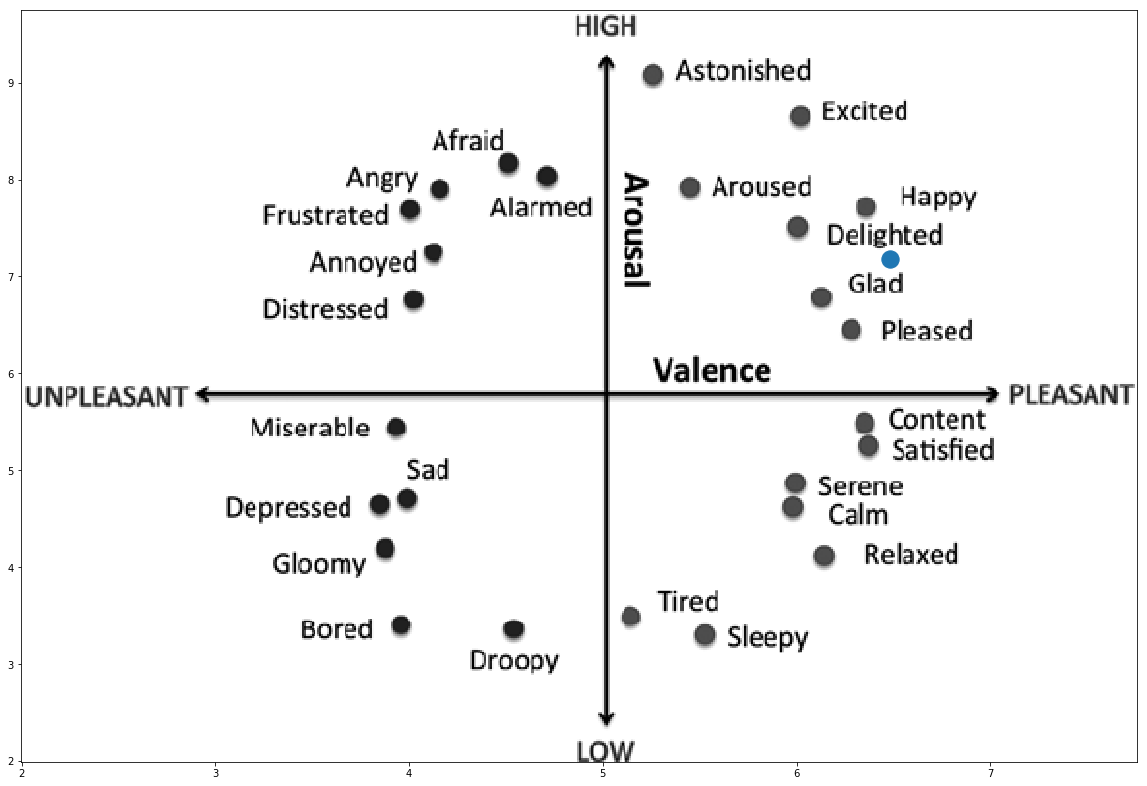

In [35]:
fig,az = plt.subplots()
az.imshow(np.flipud(img), cmap='gray', origin='lower')

# Rewrite x,y ticks

az.set_xticks(ticklx)
az.set_yticks(tickly)
az.set_xticklabels(ticklx.astype('int'))
az.set_yticklabels(tickly.astype('int'))
az.yaxis.set_major_locator(AutoLocator())
az.xaxis.set_major_locator(AutoLocator())
plt.scatter(xAxis[val1], yAxis[arous1],s=300)

plt.show()